In [187]:
# Import necessary libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

from scipy.spatial import cKDTree
import xgboost as xgb

from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
import re
import math
RSEED = 34

### Feature Engineering
1. Use KNN to get number of expected patients with disease that month using closest nearing hospital (latitude and logitude) data 
2. Drop repeated data.
3. Use correlation, PCA, and mutual information
4. USe a CNN on a time series to predict the numbers of each disease and use it as a feature
5. If cholera close by increase score that cholera is likely
6. Cluster locations to then use the clusters for time sereis analysis
7. Create clusters using the the weather of locations (kmeans (precipitation in month) or knn)


In [188]:
# Load datasets
train = pd.read_csv("Train.csv")
test = pd.read_csv("Test.csv")
toilets = pd.read_csv("toilets.csv")
waste_management = pd.read_csv("waste_management.csv")
water_sources = pd.read_csv("water_sources.csv")

In [189]:
train.head(5)

ID  Total  \
0  ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_202...    0.0   
1  ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_202...    0.0   
2  ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_202...    0.0   
3  ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_202...    0.0   
4  ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_202...    0.0   

                                  Location  \
0  ID_3a11929e-3317-476d-99f7-1bd9fb58f018   
1  ID_3a11929e-3317-476d-99f7-1bd9fb58f018   
2  ID_3a11929e-3317-476d-99f7-1bd9fb58f018   
3  ID_3a11929e-3317-476d-99f7-1bd9fb58f018   
4  ID_3a11929e-3317-476d-99f7-1bd9fb58f018   

          Category_Health_Facility_UUID    Disease  Month  Year  \
0  a9280aca-c872-46f5-ada7-4a7cc31cf6ec  Dysentery     12  2022   
1  a9280aca-c872-46f5-ada7-4a7cc31cf6ec    Typhoid     12  2022   
2  a9280aca-c872-46f5-ada7-4a7cc31cf6ec   Diarrhea     12  2022   
3  a9280aca-c872-46f5-ada7-4a7cc31cf6ec   Diarrhea     12  2022   
4  a9280aca-c872-46f5-ada7-4a7cc31cf6ec   Diarrhea     12  2022   

   Transformed_Latitude  Transformed_Longitude  
0              -8.62982               68.23267  
1              -8.62982               68.23267  
2              -8.62982               68.23267  
3              -8.62982               68.23267  
4              -8.62982               68.23267

In [190]:
display("Train Data", train["Year"].unique(), "Test Data", test["Year"].unique())

'Train Data'

array([2022, 2021, 2020, 2019], dtype=int64)

'Test Data'

array([2023], dtype=int64)

In [191]:
display("Train Info", train.info(), "Test Info", test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23848 entries, 0 to 23847
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   ID                             23848 non-null  object 
 1   Total                          23847 non-null  float64
 2   Location                       23848 non-null  object 
 3   Category_Health_Facility_UUID  23848 non-null  object 
 4   Disease                        23848 non-null  object 
 5   Month                          23848 non-null  int64  
 6   Year                           23848 non-null  int64  
 7   Transformed_Latitude           23848 non-null  float64
 8   Transformed_Longitude          23848 non-null  float64
dtypes: float64(3), int64(2), object(4)
memory usage: 1.6+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4872 entries, 0 to 4871
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
--- 

'Train Info'

None

'Test Info'

None

In [192]:
display("Train", train.isna().sum(), "Test", test.isna().sum())

'Train'

ID                               0
Total                            1
Location                         0
Category_Health_Facility_UUID    0
Disease                          0
Month                            0
Year                             0
Transformed_Latitude             0
Transformed_Longitude            0
dtype: int64

'Test'

Location                         0
Disease                          0
Month                            0
Category_Health_Facility_UUID    0
Year                             0
Transformed_Latitude             0
Transformed_Longitude            0
ID                               0
dtype: int64

In [193]:
train = train[~train['Total'].isna()].copy()

In [194]:
# Combine train and test datasets for consistent preprocessing
hospital_data = pd.concat([train, test])

In [195]:
# Drop unnecessary columns from supplementary datasets
for df in [toilets, waste_management, water_sources]:
    df.drop(columns=['Month'], inplace=True)

In [196]:

display("Train", train.columns, "Test", test.columns, "toilets", toilets.columns, "Waste", waste_management.columns, "Water", water_sources.columns)

'Train'

Index(['ID', 'Total', 'Location', 'Category_Health_Facility_UUID', 'Disease',
       'Month', 'Year', 'Transformed_Latitude', 'Transformed_Longitude'],
      dtype='object')

'Test'

Index(['Location', 'Disease', 'Month', 'Category_Health_Facility_UUID', 'Year',
       'Transformed_Latitude', 'Transformed_Longitude', 'ID'],
      dtype='object')

'toilets'

Index(['Year', '10u', '10v', '2d', '2t', 'evabs', 'evaow', 'evatc', 'evavt',
       'albedo', 'lshf', 'lai_hv', 'lai_lv', 'pev', 'ro', 'src', 'skt', 'es',
       'stl1', 'stl2', 'stl3', 'stl4', 'ssro', 'slhf', 'ssr', 'str', 'sp',
       'sro', 'sshf', 'ssrd', 'strd', 'e', 'tp', 'swvl1', 'swvl2', 'swvl3',
       'swvl4', 'Transformed_Latitude', 'Transformed_Longitude', 'Month_Year',
       'lat_lon', 'Month_Year_lat_lon'],
      dtype='object')

'Waste'

Index(['Year', '10u', '10v', '2d', '2t', 'evabs', 'evaow', 'evatc', 'evavt',
       'albedo', 'lshf', 'lai_hv', 'lai_lv', 'pev', 'ro', 'src', 'skt', 'es',
       'stl1', 'stl2', 'stl3', 'stl4', 'ssro', 'slhf', 'ssr', 'str', 'sp',
       'sro', 'sshf', 'ssrd', 'strd', 'e', 'tp', 'swvl1', 'swvl2', 'swvl3',
       'swvl4', 'Transformed_Latitude', 'Transformed_Longitude', 'Month_Year',
       'lat_lon', 'Month_Year_lat_lon'],
      dtype='object')

'Water'

Index(['Year', '10u', '10v', '2d', '2t', 'evabs', 'evaow', 'evatc', 'evavt',
       'albedo', 'lshf', 'lai_hv', 'lai_lv', 'pev', 'ro', 'src', 'skt', 'es',
       'stl1', 'stl2', 'stl3', 'stl4', 'ssro', 'slhf', 'ssr', 'str', 'sp',
       'sro', 'sshf', 'ssrd', 'strd', 'e', 'tp', 'swvl1', 'swvl2', 'swvl3',
       'swvl4', 'Transformed_Latitude', 'Transformed_Longitude', 'Month_Year',
       'lat_lon', 'Month_Year_lat_lon'],
      dtype='object')

In [197]:
# Rename columns for clarity
def rename_columns(df, prefix):
    for col in df.columns:
        if col not in ['Month_Year_lat_lon', 'lat_lon']:
            df.rename(columns={col: f"{prefix}_{col}"}, inplace=True)

rename_columns(toilets, "toilet")
rename_columns(waste_management, "waste")
rename_columns(water_sources, "water")


In [198]:
# Fill missing values in the 'Total' column
hospital_data['Total'].fillna(0, inplace=True)

In [199]:
# Drop rows with missing latitude and longitude in water sources
water_sources.dropna(subset=['water_Transformed_Latitude'], inplace=True)

In [200]:
# Visualize locations for a specific year and month
# Note the months/year should in the given timeframe [2019, 2023]
def plot_locations(year=2022, month=1, month_name='January'):
    if year < 2019 or year > 2023:
        print("Invalid year. Please choose a year between 2019 and 2023.")
        return

    if month < 1 or month > 12:
        print("Invalid month. Please choose a month between 1 and 12.")
        return

    if month_name.capitalize() not in ['January', 'February', 'March',
                                       'April', 'May', 'June', 'July',
                                       'August', 'September', 'October',
                                       'November', 'December']:
        print("Invalid month name. Please choose from 'January' to 'December'.")
        return

    plt.figure(figsize=(12, 8))
    subsets = [
        (hospital_data.query(f"Year == {year} and Month == {month}"), 'Transformed', 'Hospital', 's'),
        (water_sources.query(f"water_Month_Year == '{month}_{year}'"), 'water_Transformed', 'Water', 'o'),
        (waste_management.query(f"waste_Month_Year == '{month}_{year}'"), 'waste_Transformed', 'Waste', 'x'),
        (toilets.query(f"toilet_Month_Year == '{month}_{year}'"), 'toilet_Transformed', 'Toilet', '^'),
    ]
    for df, prefix, label, marker in subsets:
        plt.scatter(df[f'{prefix}_Longitude'], df[f'{prefix}_Latitude'], label=label, alpha=0.6, marker=marker)
    plt.title(f'Locations ({month_name.capitalize()} {year})')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.grid(True)
    plt.show()

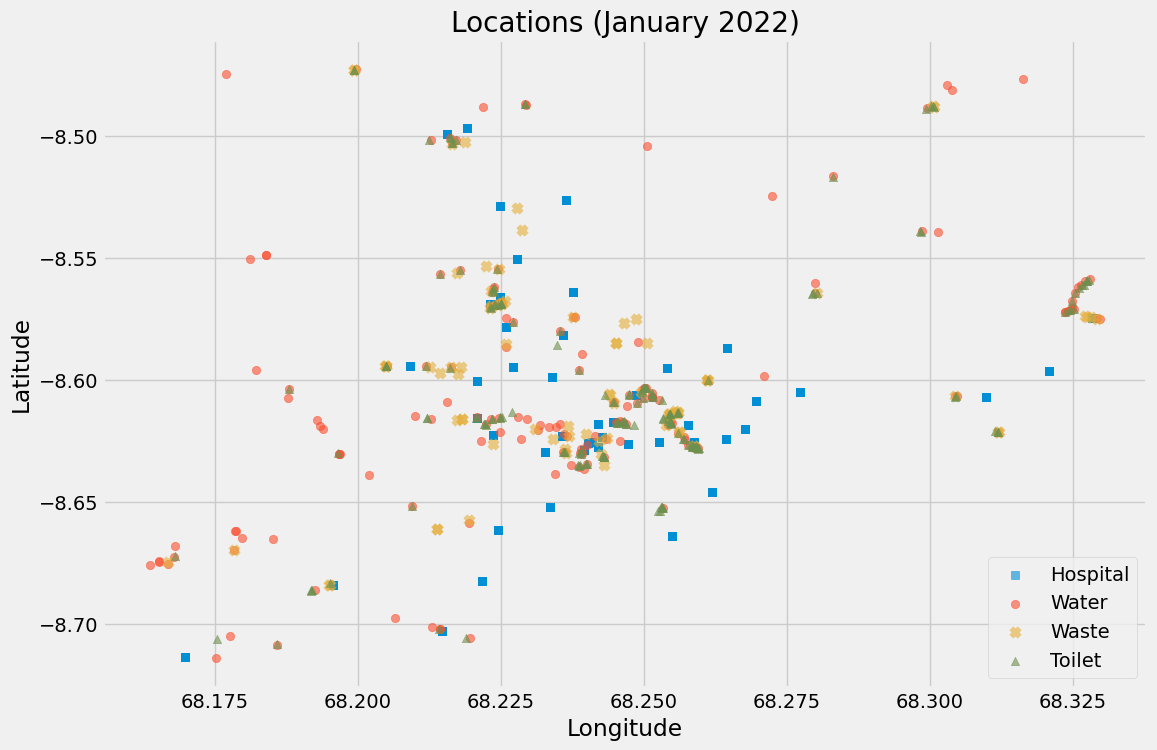

In [201]:
plot_locations()

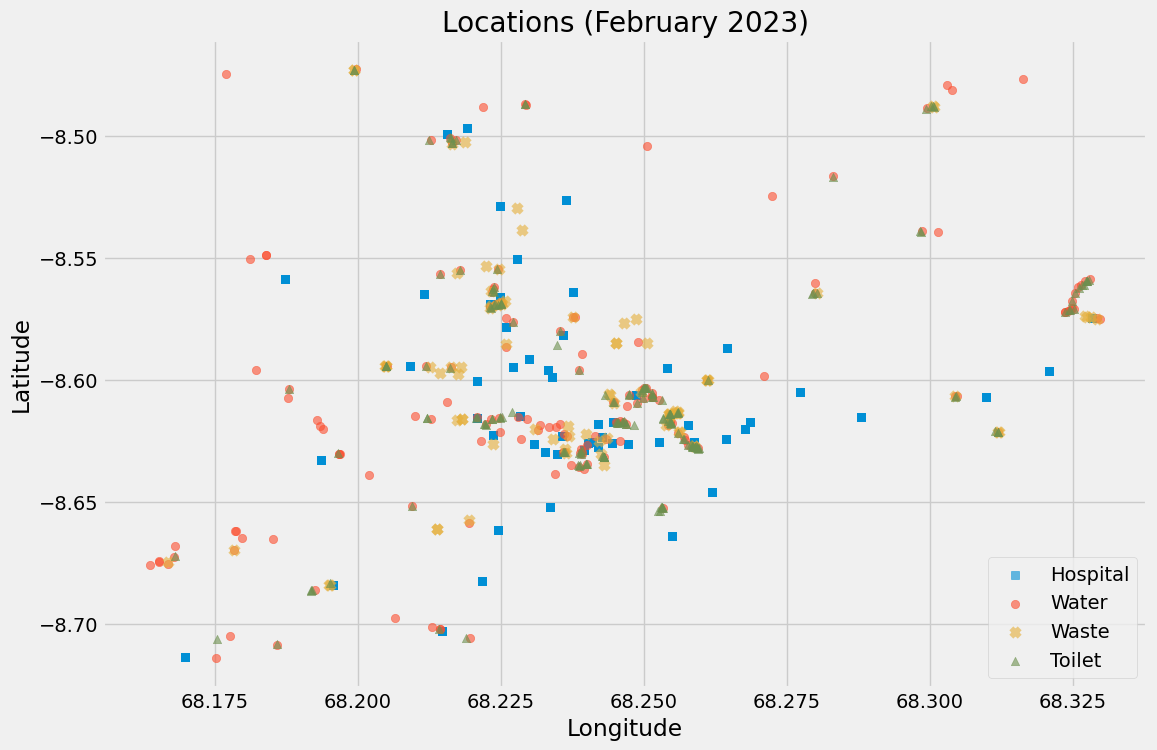

In [202]:
plot_locations(year=2023, month=2, month_name='February')

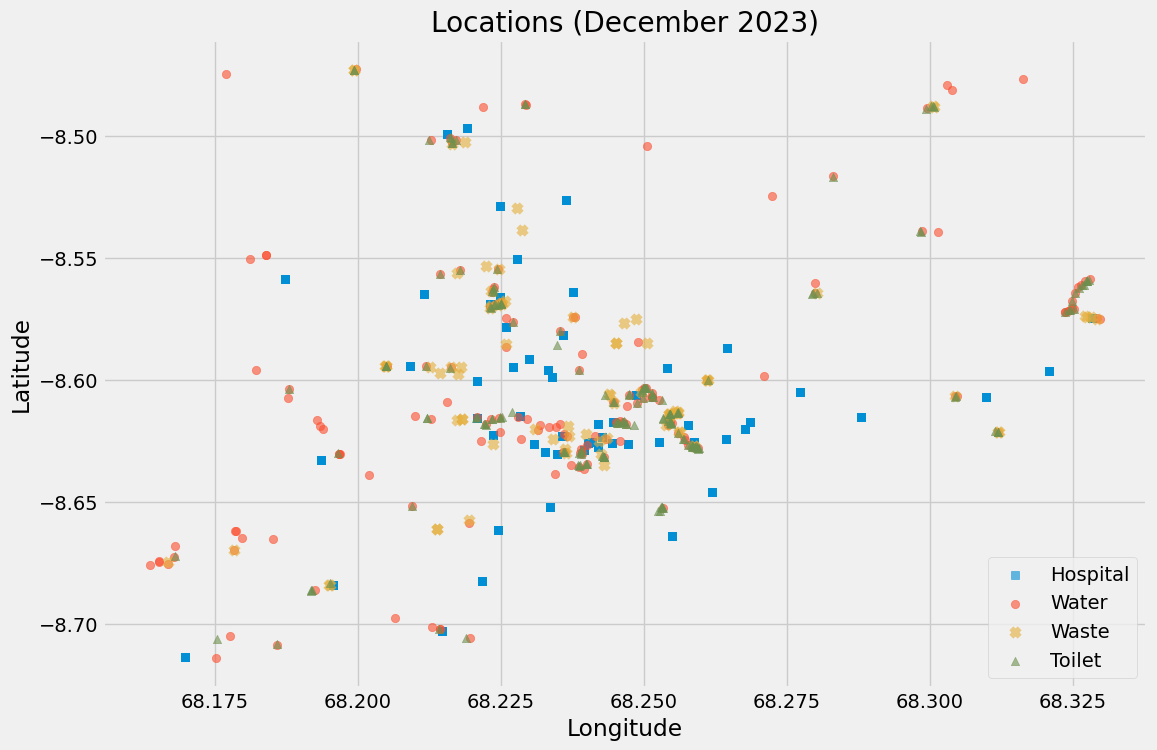

In [203]:
plot_locations(year=2023, month=12, month_name='December')

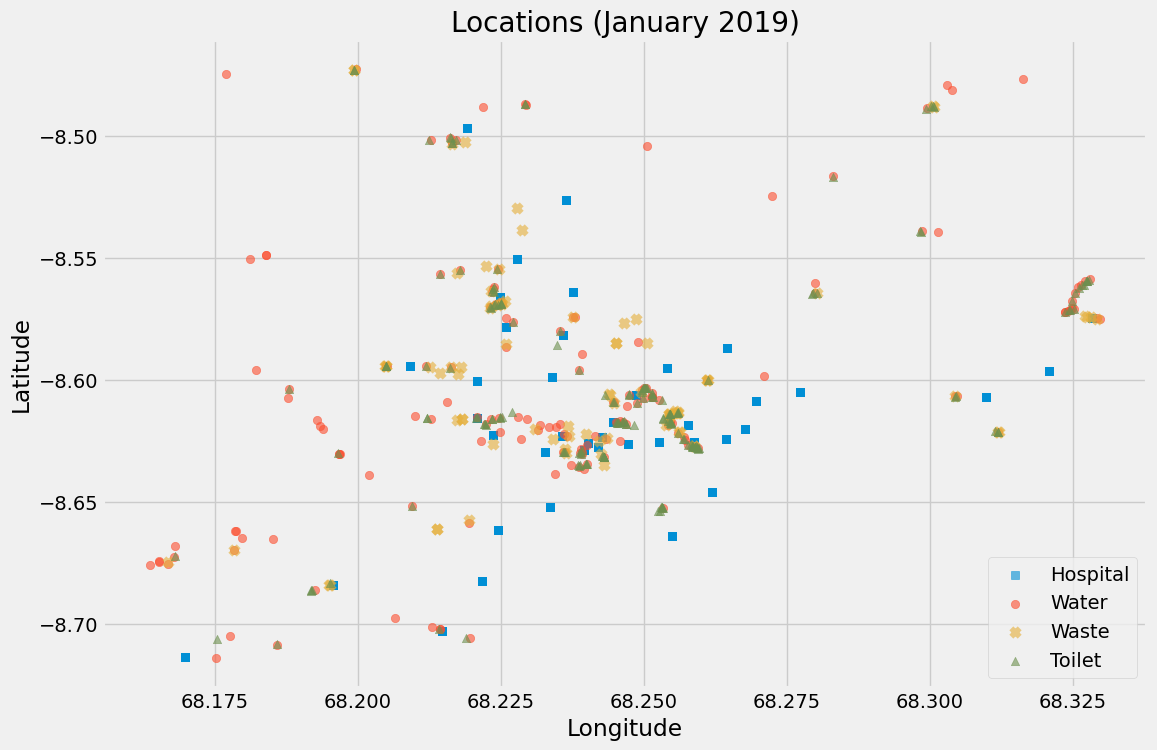

In [204]:
plot_locations(year=2019, month=1, month_name='January')

In [205]:
def find_nearest(hospital_df, location_df, lat_col, lon_col, id_col):
    # Create a cKDTree for efficient nearest neighbour search
    tree = cKDTree(location_df[[lat_col, lon_col]].values)
    nearest = {}
    # Loop through each hospital and find the nearest site in location_df
    for _, row in hospital_df.iterrows():
        _, idx = tree.query([row['Transformed_Latitude'], row['Transformed_Longitude']])
        nearest[row['ID']] = location_df.iloc[idx][id_col]
    return nearest


In [206]:
# Ensure unique identifier columns exist in all supplementary datasets
for df, prefix in [(toilets, 'toilet'), (waste_management, 'waste'), (water_sources, 'water')]:
    df[f"{prefix}_Month_Year_lat_lon"] = (
        df[f"{prefix}_Month_Year"] + '_' +
        df[f"{prefix}_Transformed_Latitude"].astype(str) + '_' +
        df[f"{prefix}_Transformed_Longitude"].astype(str)
    )

In [207]:
toilets.head()

toilet_Year  toilet_10u  toilet_10v  toilet_2d  toilet_2t  toilet_evabs  \
0         2019   -1.006850   -0.714544    293.502    297.417     -0.002489   
1         2019   -1.408560   -0.662555    292.943    297.978     -0.002556   
2         2019   -0.892110   -0.449448    293.250    297.989     -0.002535   
3         2019   -0.392348    0.384925    293.934    296.542     -0.001748   
4         2019   -0.447104    0.581028    292.571    294.726     -0.001374   

   toilet_evaow  toilet_evatc  toilet_evavt  toilet_albedo  ...  toilet_swvl1  \
0     -0.001031     -0.000989 -3.445890e-08       0.173221  ...      0.346542   
1     -0.001076     -0.000734 -3.818420e-08       0.173808  ...      0.254517   
2     -0.000980     -0.000713 -3.678720e-08       0.178823  ...      0.278152   
3     -0.000658     -0.001343 -2.700840e-08       0.180959  ...      0.385513   
4     -0.000462     -0.001139 -2.048910e-08       0.182375  ...      0.397659   

   toilet_swvl2  toilet_swvl3  toilet_swvl4  toilet_Transformed_Latitude  \
0      0.335724      0.264359      0.300018                     -8.61768   
1      0.259918      0.281769      0.296188                     -8.61768   
2      0.284195      0.261597      0.291672                     -8.61768   
3      0.378616      0.309784      0.288925                     -8.61768   
4      0.400055      0.392654      0.309311                     -8.61768   

   toilet_Transformed_Longitude  toilet_Month_Year            lat_lon  \
0                      68.24536             1_2019  -8.61768_68.24536   
1                      68.24536             2_2019  -8.61768_68.24536   
2                      68.24536             3_2019  -8.61768_68.24536   
3                      68.24536             4_2019  -8.61768_68.24536   
4                      68.24536             5_2019  -8.61768_68.24536   

         Month_Year_lat_lon  toilet_Month_Year_lat_lon  
0  1_2019_-8.61768_68.24536   1_2019_-8.61768_68.24536  
1  2_2019_-8.61768_68.24536   2_2019_-8.61768_68.24536  
2  3_2019_-8.61768_68.24536   3_2019_-8.61768_68.24536  
3  4_2019_-8.61768_68.24536   4_2019_-8.61768_68.24536  
4  5_2019_-8.61768_68.24536   5_2019_-8.61768_68.24536  

[5 rows x 43 columns]

In [208]:
# Merge datasets with nearest locations
merged_data = hospital_data.copy()
datasets = [
    (toilets, 'toilet', 'toilet_Month_Year_lat_lon'),
    (waste_management, 'waste', 'waste_Month_Year_lat_lon'),
    (water_sources, 'water', 'water_Month_Year_lat_lon'),
]

In [209]:
for df, prefix, id_col in datasets:
    nearest = find_nearest(merged_data, df, f"{prefix}_Transformed_Latitude", f"{prefix}_Transformed_Longitude", id_col)
    nearest_df = pd.DataFrame(list(nearest.items()), columns=['ID', id_col])
    merged_data = merged_data.merge(nearest_df, on="ID").merge(df, on=id_col)

In [210]:
radius = 0.05

def number_of_nearest(row, resosurce_df):
    x = row['Transformed_Longitude']
    y = row['Transformed_Latitude']
    tree = cKDTree(resosurce_df[['water_Transformed_Longitude','water_Transformed_Latitude']].values)
    indices = tree.query_ball_point([x,y], r=radius)
    return len(indices)


merged_data['number_of_water_sources'] = merged_data.apply(lambda row: number_of_nearest(row, water_sources), axis=1)
numerical_col = ['number_of_water_sources']

In [211]:
def number_of_nearest_toilets(row, resosurce_df):
    x = row['Transformed_Longitude']
    y = row['Transformed_Latitude']
    tree = cKDTree(resosurce_df[['toilet_Transformed_Longitude','toilet_Transformed_Latitude']].values)
    indices = tree.query_ball_point([x,y], r=radius)
    return len(indices)


merged_data['number_of_toilets_sources'] = merged_data.apply(lambda row: number_of_nearest_toilets(row, toilets), axis=1)
numerical_col.append('number_of_toilets_sources')

In [212]:
def number_of_nearest_waste(row, resosurce_df):
    x = row['Transformed_Longitude']
    y = row['Transformed_Latitude']
    tree = cKDTree(resosurce_df[['waste_Transformed_Longitude','waste_Transformed_Latitude']].values)
    indices = tree.query_ball_point([x,y], r=radius)
    return len(indices)


merged_data['number_of_waste_sources'] = merged_data.apply(lambda row: number_of_nearest_waste(row, waste_management), axis=1)
numerical_col.append('number_of_waste_sources')

In [213]:
merged_data.columns

Index(['ID', 'Total', 'Location', 'Category_Health_Facility_UUID', 'Disease',
       'Month', 'Year', 'Transformed_Latitude', 'Transformed_Longitude',
       'toilet_Month_Year_lat_lon',
       ...
       'water_swvl3', 'water_swvl4', 'water_Transformed_Latitude',
       'water_Transformed_Longitude', 'water_Month_Year', 'lat_lon',
       'Month_Year_lat_lon', 'number_of_water_sources',
       'number_of_toilets_sources', 'number_of_waste_sources'],
      dtype='object', length=141)

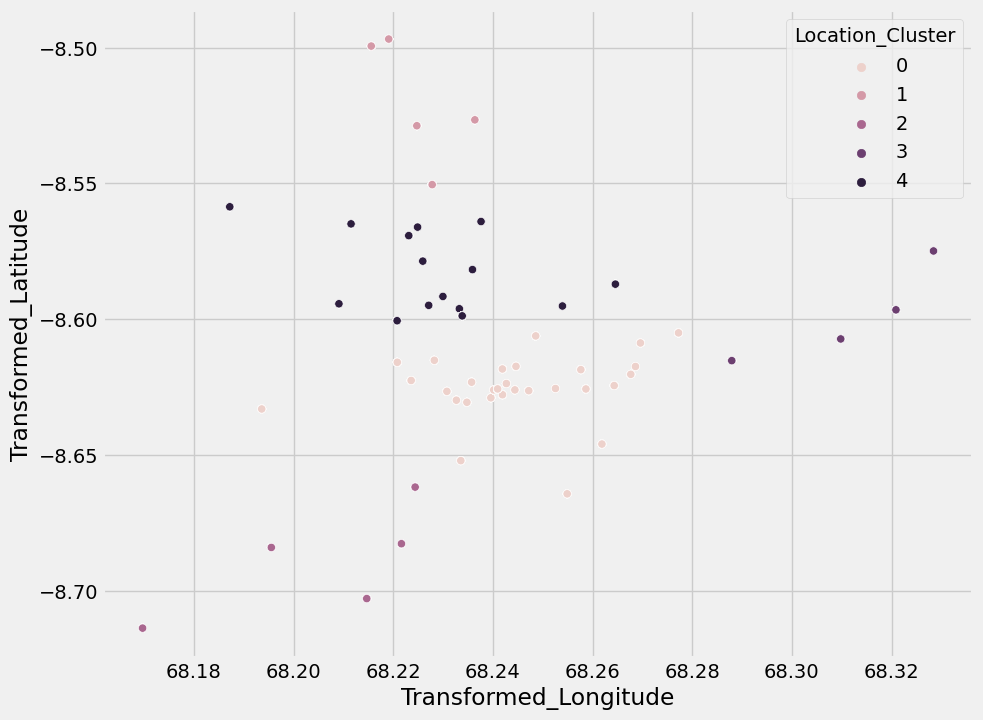

In [214]:
#Cluster Hospitals
number_of_clusters = 5

km = KMeans(init="k-means++", n_clusters=number_of_clusters, n_init=12)
km.fit(merged_data[['Transformed_Latitude', 'Transformed_Longitude']])
merged_data['Location_Cluster'] = pd.DataFrame(km.labels_, columns=['Location_Cluster'])
plt.figure(figsize=(10,8))
sns.scatterplot(y=merged_data['Transformed_Latitude'],x=merged_data['Transformed_Longitude'], hue=merged_data['Location_Cluster'], data=merged_data )
plt.show()


In [215]:
# pattern = r'^toilet_'
# toilet_col_to_drop = [col for col in merged_data.columns if re.match(pattern, col)]
# toilet_col_to_drop.remove('toilet_Transformed_Latitude')
# toilet_col_to_drop.remove('toilet_Transformed_Longitude')
# toilet_col_to_drop.remove('toilet_tp')


In [216]:
# pattern = r'^water_'
# toilet_col_to_drop = [col for col in merged_data.columns if re.match(pattern, col)]
# toilet_col_to_drop.remove('water_Transformed_Latitude')
# toilet_col_to_drop.remove('water_Transformed_Longitude')
# toilet_col_to_drop.remove('water_tp')
# toilet_col_to_drop.remove('water_swvl1')

In [217]:
# pattern = r'^waste_'
# waste_col_to_drop = [col for col in merged_data.columns if re.match(pattern, col)]
# waste_col_to_drop.remove('waste_Transformed_Latitude')
# waste_col_to_drop.remove('waste_Transformed_Longitude')
# waste_col_to_drop.remove('waste_tp')
# toilet_col_to_drop.remove('water_ssr')

In [218]:
merged_data.head()

ID  Total  \
0  ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_202...    0.0   
1  ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_202...    0.0   
2  ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_202...    0.0   
3  ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_202...    0.0   
4  ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_202...    0.0   

                                  Location  \
0  ID_3a11929e-3317-476d-99f7-1bd9fb58f018   
1  ID_3a11929e-3317-476d-99f7-1bd9fb58f018   
2  ID_3a11929e-3317-476d-99f7-1bd9fb58f018   
3  ID_3a11929e-3317-476d-99f7-1bd9fb58f018   
4  ID_3a11929e-3317-476d-99f7-1bd9fb58f018   

          Category_Health_Facility_UUID    Disease  Month  Year  \
0  a9280aca-c872-46f5-ada7-4a7cc31cf6ec  Dysentery     12  2022   
1  a9280aca-c872-46f5-ada7-4a7cc31cf6ec    Typhoid     12  2022   
2  a9280aca-c872-46f5-ada7-4a7cc31cf6ec   Diarrhea     12  2022   
3  a9280aca-c872-46f5-ada7-4a7cc31cf6ec   Diarrhea     12  2022   
4  a9280aca-c872-46f5-ada7-4a7cc31cf6ec   Diarrhea     12  2022   

   Transformed_Latitude  Transformed_Longitude toilet_Month_Year_lat_lon  ...  \
0              -8.62982               68.23267  2_2021_-8.62979_68.23582  ...   
1              -8.62982               68.23267  2_2021_-8.62979_68.23582  ...   
2              -8.62982               68.23267  2_2021_-8.62979_68.23582  ...   
3              -8.62982               68.23267  2_2021_-8.62979_68.23582  ...   
4              -8.62982               68.23267  2_2021_-8.62979_68.23582  ...   

   water_swvl4  water_Transformed_Latitude  water_Transformed_Longitude  \
0     0.391357                    -8.62966                     68.23589   
1     0.391357                    -8.62966                     68.23589   
2     0.391357                    -8.62966                     68.23589   
3     0.391357                    -8.62966                     68.23589   
4     0.391357                    -8.62966                     68.23589   

   water_Month_Year            lat_lon        Month_Year_lat_lon  \
0            6_2020  -8.62966_68.23589  6_2020_-8.62966_68.23589   
1            6_2020  -8.62966_68.23589  6_2020_-8.62966_68.23589   
2            6_2020  -8.62966_68.23589  6_2020_-8.62966_68.23589   
3            6_2020  -8.62966_68.23589  6_2020_-8.62966_68.23589   
4            6_2020  -8.62966_68.23589  6_2020_-8.62966_68.23589   

   number_of_water_sources  number_of_toilets_sources  \
0                     5580                       6840   
1                     5580                       6840   
2                     5580                       6840   
3                     5580                       6840   
4                     5580                       6840   

   number_of_waste_sources  Location_Cluster  
0                     3120                 0  
1                     3120                 0  
2                     3120                 0  
3                     3120                 0  
4                     3120                 0  

[5 rows x 142 columns]

In [219]:
merged_data_trim_toilet = merged_data
merged_data_trim_toilet.head(3)

ID  Total  \
0  ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_202...    0.0   
1  ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_202...    0.0   
2  ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_202...    0.0   

                                  Location  \
0  ID_3a11929e-3317-476d-99f7-1bd9fb58f018   
1  ID_3a11929e-3317-476d-99f7-1bd9fb58f018   
2  ID_3a11929e-3317-476d-99f7-1bd9fb58f018   

          Category_Health_Facility_UUID    Disease  Month  Year  \
0  a9280aca-c872-46f5-ada7-4a7cc31cf6ec  Dysentery     12  2022   
1  a9280aca-c872-46f5-ada7-4a7cc31cf6ec    Typhoid     12  2022   
2  a9280aca-c872-46f5-ada7-4a7cc31cf6ec   Diarrhea     12  2022   

   Transformed_Latitude  Transformed_Longitude toilet_Month_Year_lat_lon  ...  \
0              -8.62982               68.23267  2_2021_-8.62979_68.23582  ...   
1              -8.62982               68.23267  2_2021_-8.62979_68.23582  ...   
2              -8.62982               68.23267  2_2021_-8.62979_68.23582  ...   

   water_swvl4  water_Transformed_Latitude  water_Transformed_Longitude  \
0     0.391357                    -8.62966                     68.23589   
1     0.391357                    -8.62966                     68.23589   
2     0.391357                    -8.62966                     68.23589   

   water_Month_Year            lat_lon        Month_Year_lat_lon  \
0            6_2020  -8.62966_68.23589  6_2020_-8.62966_68.23589   
1            6_2020  -8.62966_68.23589  6_2020_-8.62966_68.23589   
2            6_2020  -8.62966_68.23589  6_2020_-8.62966_68.23589   

   number_of_water_sources  number_of_toilets_sources  \
0                     5580                       6840   
1                     5580                       6840   
2                     5580                       6840   

   number_of_waste_sources  Location_Cluster  
0                     3120                 0  
1                     3120                 0  
2                     3120                 0  

[3 rows x 142 columns]

In [220]:
merged_data_trim_toilet.shape

(29331, 142)

In [221]:
merged_data_trim_toilet.columns

Index(['ID', 'Total', 'Location', 'Category_Health_Facility_UUID', 'Disease',
       'Month', 'Year', 'Transformed_Latitude', 'Transformed_Longitude',
       'toilet_Month_Year_lat_lon',
       ...
       'water_swvl4', 'water_Transformed_Latitude',
       'water_Transformed_Longitude', 'water_Month_Year', 'lat_lon',
       'Month_Year_lat_lon', 'number_of_water_sources',
       'number_of_toilets_sources', 'number_of_waste_sources',
       'Location_Cluster'],
      dtype='object', length=142)

In [222]:
merged_data_trim_toilet.groupby('Disease')['Total'].count()

Disease
Cholera              734
Diarrhea            7352
Dysentery           2899
Intestinal Worms    2924
Malaria             9571
Schistosomiasis     2925
Typhoid             2926
Name: Total, dtype: int64

In [223]:
merged_data_trim_toilet['Disease'].unique()

array(['Dysentery', 'Typhoid', 'Diarrhea', 'Schistosomiasis', 'Malaria',
       'Intestinal Worms', 'Cholera'], dtype=object)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam



# model = Sequential([
#     Conv1D(filters=64, kernel_size=2,  activation='relu', input_shape=(look_back, 1)), 
#     MaxPooling1D(pool_size=2), 
#     Flatten(),
#     Dense(50, activation= 'relu'),
#     Dense(1),
# ])


# model.compile(optimizer='Adam', loss='mse')

def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data)-look_back-1):
        a = data[i:(i+look_back)]
        X.append(a)
        Y.append(data.iloc[i + look_back])
    return np.array(X), np.array(Y)

merged_data_trim_toilet['Predicted_Total'] = np.nan

def get_col_disease_pred(x):
    try:
        return data.loc[x]
        
    except:
        return merged_data_trim_toilet['Predicted_Total'][merged_data_trim_toilet['ID']==x]

for col in merged_data_trim_toilet['Disease'].unique()[:1]:
    for location in merged_data_trim_toilet['Location'].unique():

        print(col)
        data = merged_data_trim_toilet['Total'][(merged_data_trim_toilet['Disease']==col)&(merged_data_trim_toilet['Location']==location)]
        # print(data[-4:])

        look_back = 12

        X, y = create_dataset(data, look_back)
        X = np.expand_dims(X, axis=2)
        # print("Done")
        model = Sequential([
        Conv1D(filters=64, kernel_size=2,  activation='relu', input_shape=(look_back, 1)), 
        MaxPooling1D(pool_size=2), 
        Flatten(),
        Dense(50, activation= 'relu'),
        Dense(1),
        ])


        model.compile(optimizer='Adam', loss='mse')

        model.fit(X, y, epochs=10, verbose=1)
        #X_test = merged_data_trim_toilet['Total'][merged_data_trim_toilet['Disease']==col]
        col_name = f"{col}_prediction"
        pred_array = model.predict(X)
        #pred_array = pred_array.reshape(pred_array.shape[0])
        data[col_name] = pd.DataFrame(pred_array, columns=[col_name])
        # print(data[-4:])
        #data['ID'] = pd.DataFrame(merged_data_trim_toilet['ID'][merged_data_trim_toilet['Disease']==col], columns=['ID'])
        data = data[:-1]
        data.index = merged_data_trim_toilet['ID'][(merged_data_trim_toilet['Disease']==col)&(merged_data_trim_toilet['Location']==location)]
        # index_list = []
        # for idx in data.index:
        #     if idx in merged_data_trim_toilet.index:
        #         index_list.append(idx)
        

        merged_data_trim_toilet['Predicted_Total'] = merged_data_trim_toilet['ID'].apply(lambda x: get_col_disease_pred(x))
        display(merged_data_trim_toilet['Predicted_Total'][(merged_data_trim_toilet['Disease']==col)&(merged_data_trim_toilet['Location']==location)])

        

In [224]:

def get_previous_year_total(row):
    current_loc = row["Location"]
    current_disease = row["Disease"]
    year = row['Year']-1
    month = row['Month']
    try:
        return merged_data_trim_toilet['Total'][(merged_data_trim_toilet['Location']==current_loc)&(merged_data_trim_toilet['Disease']==current_disease)&(merged_data_trim_toilet['Year']==year)&(merged_data_trim_toilet['Month']==month)].mean()
        
    except:
        return np.nan

merged_data_trim_toilet['Previous_Year_Total'] = merged_data_trim_toilet.apply(lambda row: get_previous_year_total(row), axis=1)
numerical_col.append('Previous_Year_Total')


In [225]:

def total_per_cluster_same_year_month(row):
    #current_loc = row["Location"]
    current_disease = row["Disease"]
    year = row['Year']
    month = row['Month']
    cluster = row['Location_Cluster']
    try:
        return merged_data_trim_toilet['Total'][(merged_data_trim_toilet['Disease']==current_disease)&(merged_data_trim_toilet['Year']==year)&(merged_data_trim_toilet['Month']==month)&(merged_data_trim_toilet['Location_Cluster']==cluster)].sum()
        
    except:
        return np.nan

merged_data_trim_toilet['Total_per_cluster_same_year_month'] = merged_data_trim_toilet.apply(lambda row: total_per_cluster_same_year_month(row), axis=1)
numerical_col.append('Total_per_cluster_same_year_month')

In [226]:
# ['Dysentery', 'Typhoid', 'Diarrhea', 'Schistosomiasis', 'Malaria','Intestinal Worms', 'Cholera']


# def get_previous_years_oral_fecal_disease(row):
#     current_loc = row["Location"]
#     #current_disease = row["Disease"]
#     year = row['Year']
#     month = row['Month']
#     try:
#         return merged_data_trim_toilet['Total'][(merged_data_trim_toilet['Location']==current_loc)&(merged_data_trim_toilet['Disease']==['Dysentery','Typhoid', 'Diarrhea','Cholera' ])&(merged_data_trim_toilet['Year']<year)&(merged_data_trim_toilet['Month']==month)].sum()
        
#     except:
#         return np.nan

# merged_data_trim_toilet['Previous_Year_Total_Diarheal_Disease'] = merged_data_trim_toilet.apply(lambda row: get_previous_years_oral_fecal_disease(row), axis=1)
# numerical_col.append('Previous_Year_Total_Diarheal_Disease')


In [227]:
# ['Dysentery', 'Typhoid', 'Diarrhea', 'Schistosomiasis', 'Malaria','Intestinal Worms', 'Cholera']


# def get_previous_years_seasonal_disease(row):
#     current_loc = row["Location"]
#     #current_disease = row["Disease"]
#     year = row['Year']
#     month = row['Month']
#     try:
#         return merged_data_trim_toilet['Total'][(merged_data_trim_toilet['Location']==current_loc)&(merged_data_trim_toilet['Disease']==['Schistosomiasis', 'Malaria'])&(merged_data_trim_toilet['Year']<year)&(merged_data_trim_toilet['Month']==month)].sum()
        
#     except:
#         return np.nan

# merged_data_trim_toilet['Previous_Year_Total_Malaria_Schisto_Disease'] = merged_data_trim_toilet.apply(lambda row: get_previous_years_seasonal_disease(row), axis=1)
# numerical_col.append('Previous_Year_Total_Malaria_Schisto_Disease')

In [228]:
def distance_to_point_toilet(row):
    lat = row['toilet_Transformed_Latitude']
    long = row['toilet_Transformed_Longitude']
    #dist_squared = (lat-row['Transformed_Latitude'])**2-(long-row['Transformed_Latitude'])**2)

    distance = math.sqrt(((lat-row['Transformed_Latitude'])**2+(long-row['Transformed_Latitude'])**2))
    return distance


merged_data_trim_toilet['Distance_to_toilet'] = merged_data_trim_toilet.apply(lambda row: distance_to_point_toilet(row), axis=1)  #math.sqrt(((merged_data_trim_toilet['water_Transformed_Latitude']-merged_data_trim_toilet['Transformed_Latitude'])**2-(merged_data_trim_toilet['water_Transformed_Longitude']-merged_data_trim_toilet['Transformed_Latitude'])**2))
merged_data_trim_toilet = merged_data_trim_toilet.drop(['toilet_Transformed_Longitude', 'toilet_Transformed_Latitude'], axis=1)
numerical_col.append('Distance_to_toilet')

In [229]:
def distance_to_point_waste(row):
    lat = row['waste_Transformed_Latitude']
    long = row['waste_Transformed_Longitude']
    #dist_squared = (lat-row['Transformed_Latitude'])**2-(long-row['Transformed_Latitude'])**2)

    distance = math.sqrt(((lat-row['Transformed_Latitude'])**2+(long-row['Transformed_Latitude'])**2))
    return distance


merged_data_trim_toilet['Distance_to_waste'] = merged_data_trim_toilet.apply(lambda row: distance_to_point_waste(row), axis=1)  #math.sqrt(((merged_data_trim_toilet['water_Transformed_Latitude']-merged_data_trim_toilet['Transformed_Latitude'])**2-(merged_data_trim_toilet['water_Transformed_Longitude']-merged_data_trim_toilet['Transformed_Latitude'])**2))
merged_data_trim_toilet = merged_data_trim_toilet.drop(['waste_Transformed_Longitude', 'waste_Transformed_Latitude'], axis=1)
numerical_col.append('Distance_to_waste')

In [230]:
def distance_to_point_water(row):
    lat = row['water_Transformed_Latitude']
    long = row['water_Transformed_Longitude']
    #dist_squared = (lat-row['Transformed_Latitude'])**2-(long-row['Transformed_Latitude'])**2)

    distance = math.sqrt(((lat-row['Transformed_Latitude'])**2+(long-row['Transformed_Latitude'])**2))
    return distance


merged_data_trim_toilet['Distance_to_water'] = merged_data_trim_toilet.apply(lambda row: distance_to_point_water(row), axis=1)  #math.sqrt(((merged_data_trim_toilet['water_Transformed_Latitude']-merged_data_trim_toilet['Transformed_Latitude'])**2-(merged_data_trim_toilet['water_Transformed_Longitude']-merged_data_trim_toilet['Transformed_Latitude'])**2))
merged_data_trim_toilet = merged_data_trim_toilet.drop(['water_Transformed_Longitude', 'water_Transformed_Latitude'], axis=1)
numerical_col.append('Distance_to_water')

In [ ]:
number_of_pca_components = 6
pca = PCA(n_components=number_of_pca_components)
patterns = [r'^toilet_', r'^water_', r'^waste_' ]
for pat in patterns:
    pat = pat.strip('^')
    pca_components = [ f"{pat}_{i}" for i in range(1,7)]
    pattern = pat
    resource_cols = [col for col in merged_data_trim_toilet.columns if re.match(pattern, col)]
    pattern = pattern.strip('^')
    to_remove = [f'{pattern}Month_Year_lat_lon', f'{pattern}Month_Year']
    print(resource_cols)
    print(to_remove)
    for i in to_remove:
        resource_cols.remove(i)
    resource_cols_data = merged_data_trim_toilet[resource_cols]
    resource_cols_data_decomposed = pca.fit_transform(resource_cols_data)
    merged_data_trim_toilet[pca_components] = pd.DataFrame(resource_cols_data_decomposed, columns=[pca_components])
    merged_data_trim_toilet = merged_data_trim_toilet.drop(resource_cols, axis=1)
    numerical_col = numerical_col + pca_components

['toilet_Month_Year_lat_lon', 'toilet_Year', 'toilet_10u', 'toilet_10v', 'toilet_2d', 'toilet_2t', 'toilet_evabs', 'toilet_evaow', 'toilet_evatc', 'toilet_evavt', 'toilet_albedo', 'toilet_lshf', 'toilet_lai_hv', 'toilet_lai_lv', 'toilet_pev', 'toilet_ro', 'toilet_src', 'toilet_skt', 'toilet_es', 'toilet_stl1', 'toilet_stl2', 'toilet_stl3', 'toilet_stl4', 'toilet_ssro', 'toilet_slhf', 'toilet_ssr', 'toilet_str', 'toilet_sp', 'toilet_sro', 'toilet_sshf', 'toilet_ssrd', 'toilet_strd', 'toilet_e', 'toilet_tp', 'toilet_swvl1', 'toilet_swvl2', 'toilet_swvl3', 'toilet_swvl4', 'toilet_Month_Year']
['toilet_Month_Year_lat_lon', 'toilet_Month_Year']
['water_Month_Year_lat_lon', 'water_Year', 'water_10u', 'water_10v', 'water_2d', 'water_2t', 'water_evabs', 'water_evaow', 'water_evatc', 'water_evavt', 'water_albedo', 'water_lshf', 'water_lai_hv', 'water_lai_lv', 'water_pev', 'water_ro', 'water_src', 'water_skt', 'water_es', 'water_stl1', 'water_stl2', 'water_stl3', 'water_stl4', 'water_ssro', 'wat

In [232]:
#merged_data_trim_toilet = merged_data_trim_toilet.drop(['Month_Year_lat_lon_y', 'toilet_Month_Year', 'toilet_Month_Year_lat_lon', 'lat_lon', 'lat_lon_x', 'lat_lon_y','toilet_stl2', 'toilet_stl3', 'toilet_stl4', 'toilet_swvl2','toilet_swvl3', 'toilet_swvl4'], axis=1)

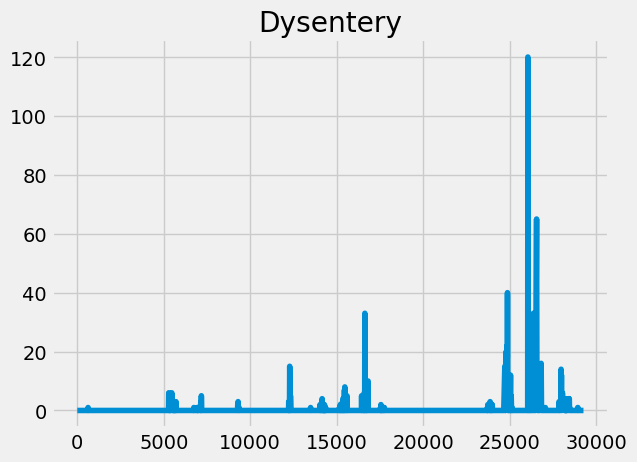

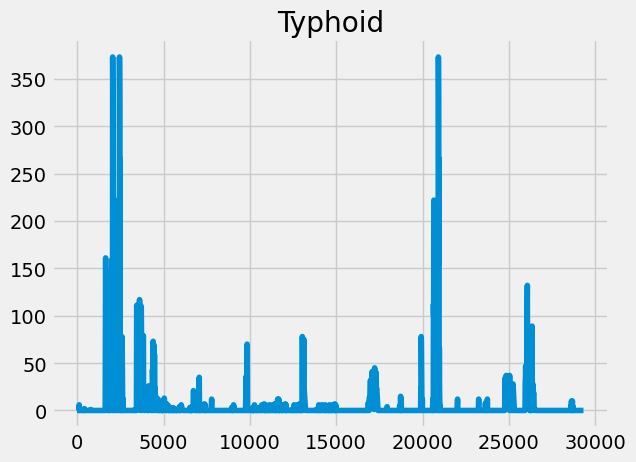

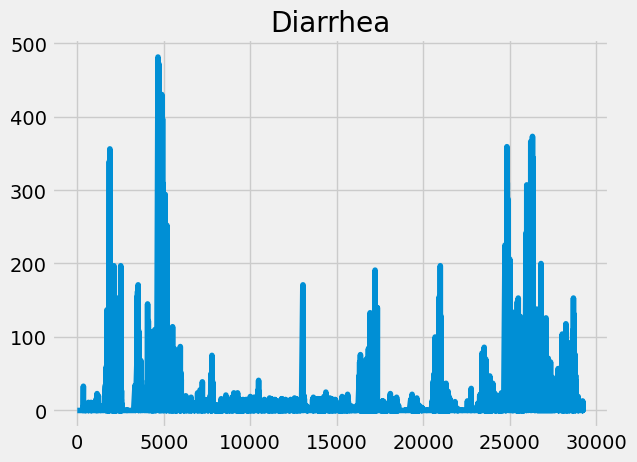

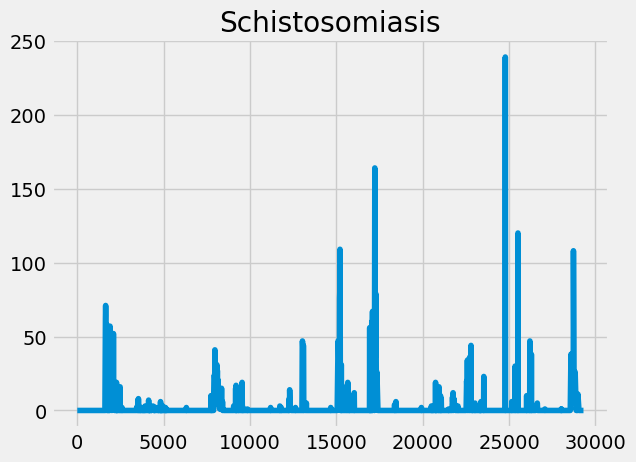

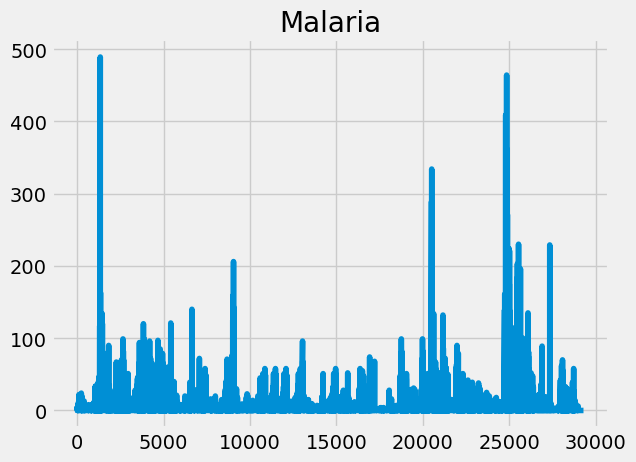

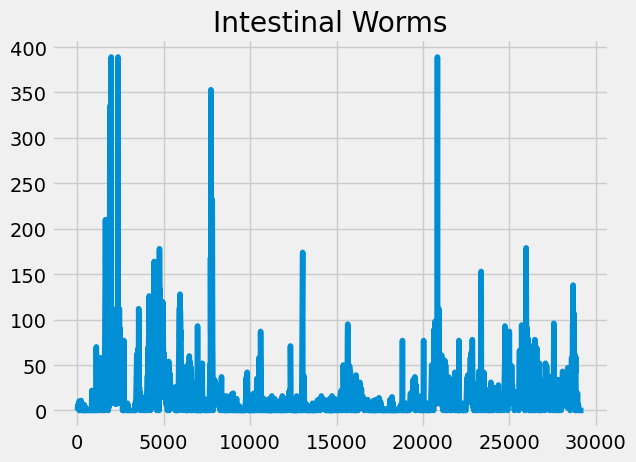

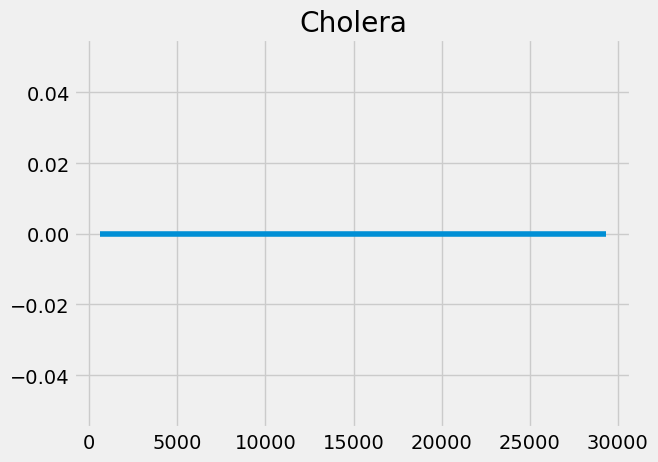

In [233]:
for col in merged_data_trim_toilet['Disease'].unique():
    plt.plot(merged_data_trim_toilet['Total'][merged_data_trim_toilet['Disease']==col])
    plt.title(col)
    plt.show()

In [234]:
merged_data_trim_toilet['Year'].unique()

array([2022, 2021, 2020, 2019, 2023], dtype=int64)

In [235]:
merged_data_trim_toilet['month_year'] = pd.to_datetime(merged_data_trim_toilet['Year'].astype(str) + '-' +merged_data_trim_toilet['Month'].astype(str))

In [236]:
merged_data_trim_toilet['month_year'].max()

Timestamp('2023-12-01 00:00:00')

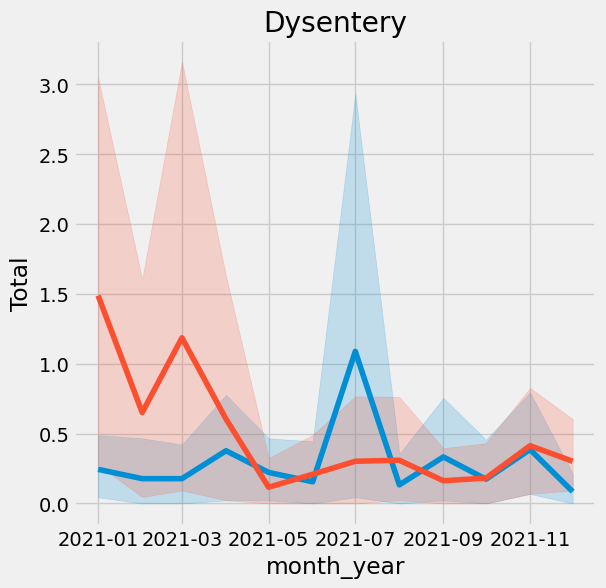

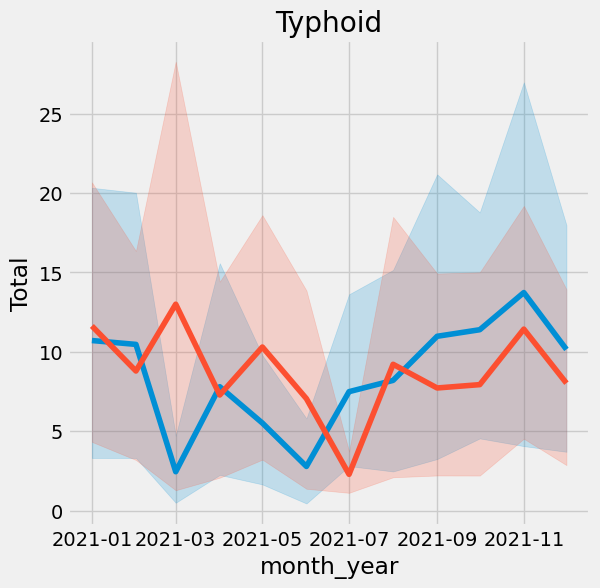

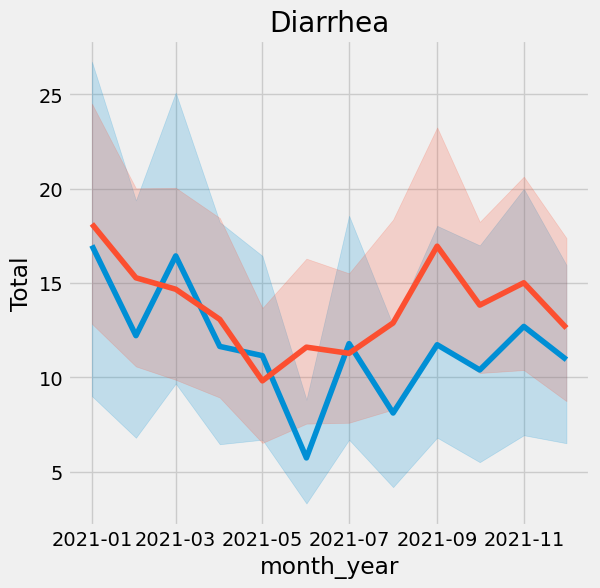

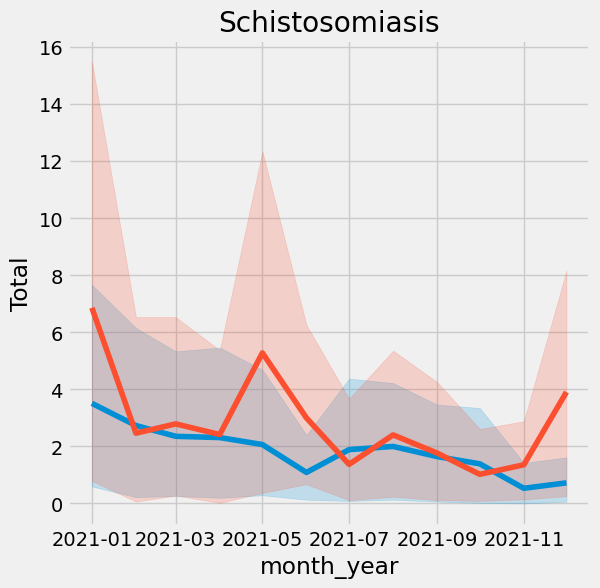

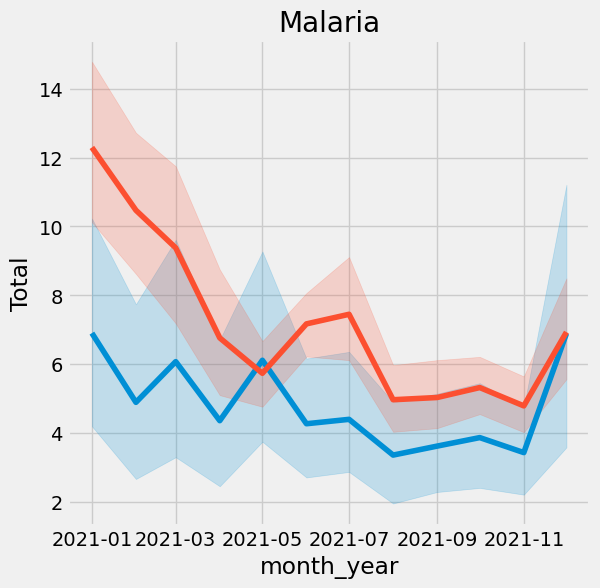

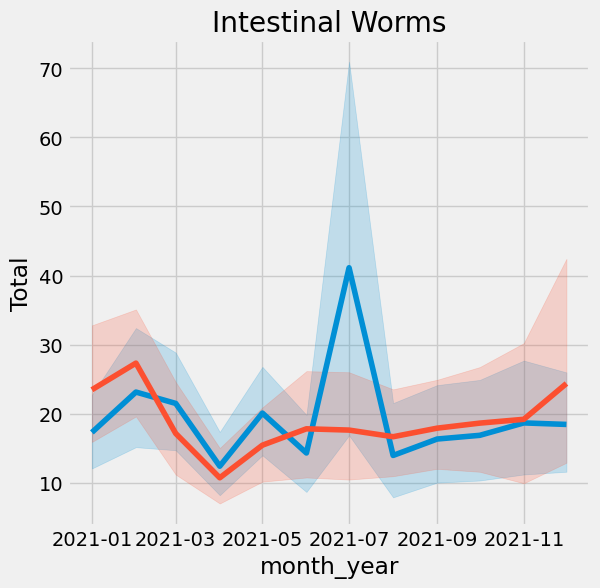

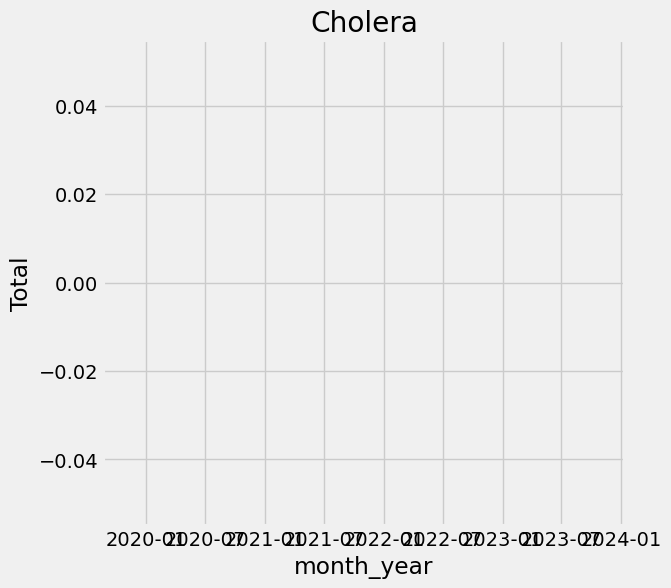

In [237]:
for col in merged_data_trim_toilet['Disease'].unique():
    data = merged_data_trim_toilet[(merged_data_trim_toilet['Disease']==col)&(merged_data_trim_toilet['Year']==2021)]
    plt.figure(figsize=(6,6))
    plt.subplot()
    sns.lineplot(y=data['Total'], x=data['month_year'], data=data)
    sns.lineplot(y=data['Previous_Year_Total'], x=data['month_year'], data=data)
    plt.title(col)
    plt.show()

<AxesSubplot:title={'center':'Malaria_time_series'}, xlabel='month_year'>

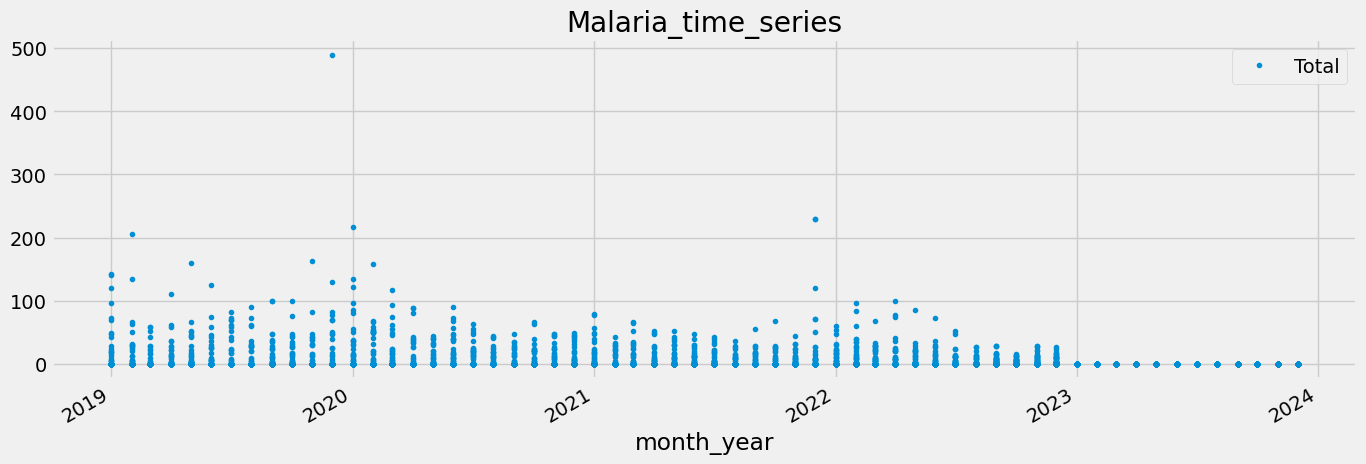

In [238]:
malaria_time_series = merged_data_trim_toilet[['month_year', 'Total']][(merged_data_trim_toilet['Disease']=='Malaria')&(merged_data_trim_toilet['Location_Cluster']==0)]

malaria_time_series = malaria_time_series.set_index('month_year')

malaria_time_series.plot(style='.', figsize=(15,5), color=color_pal[0], title='Malaria_time_series')

(360,)

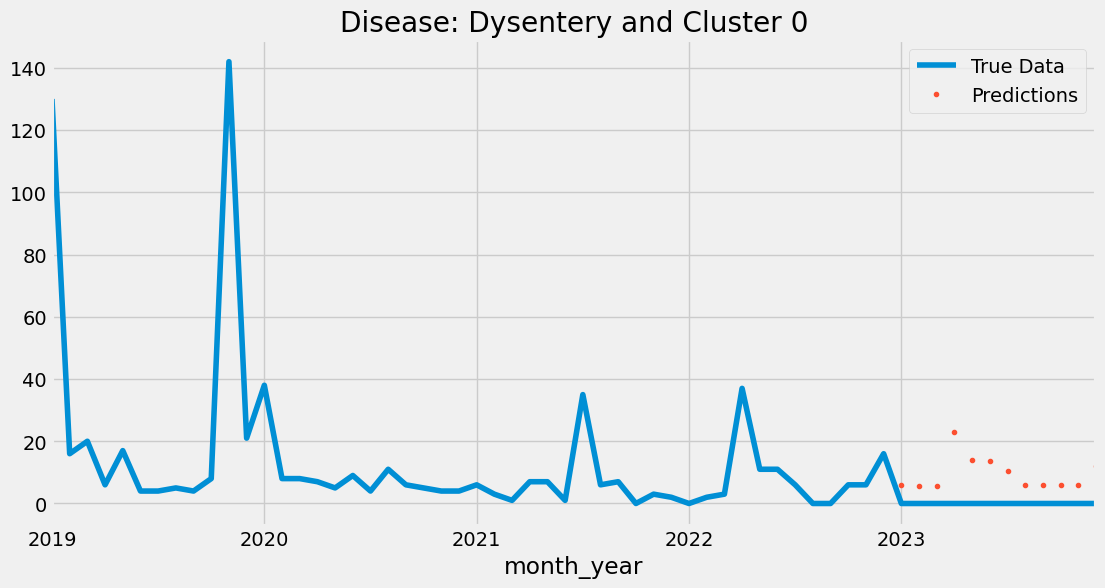

(360,)

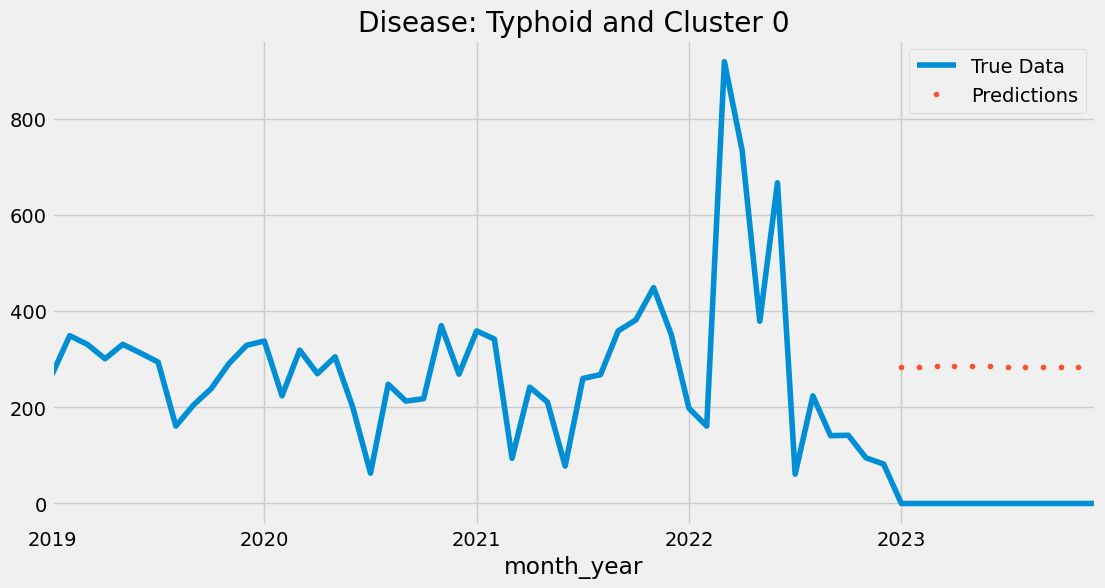

(360,)

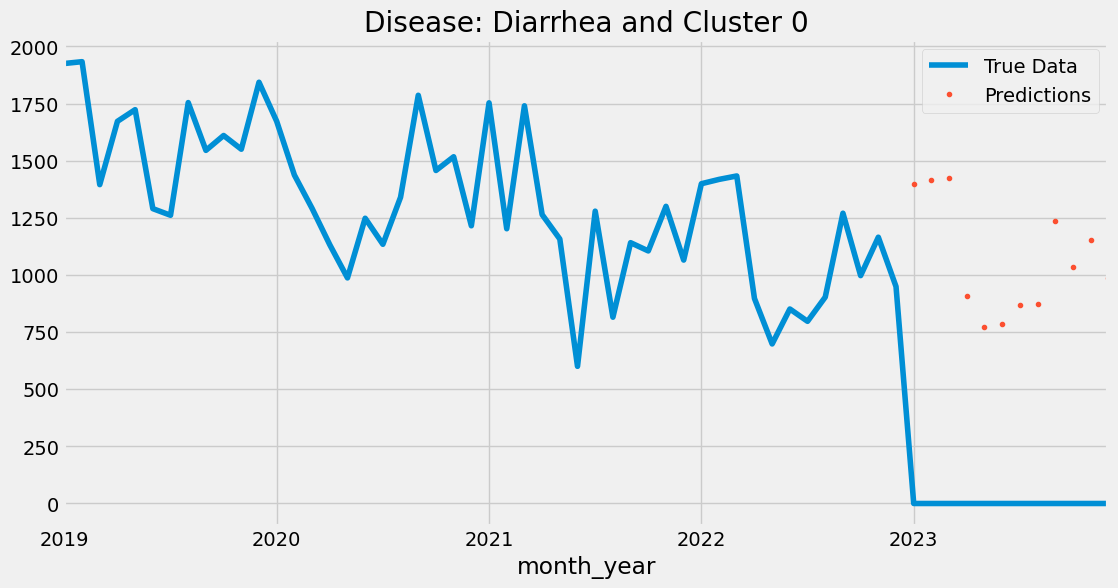

(360,)

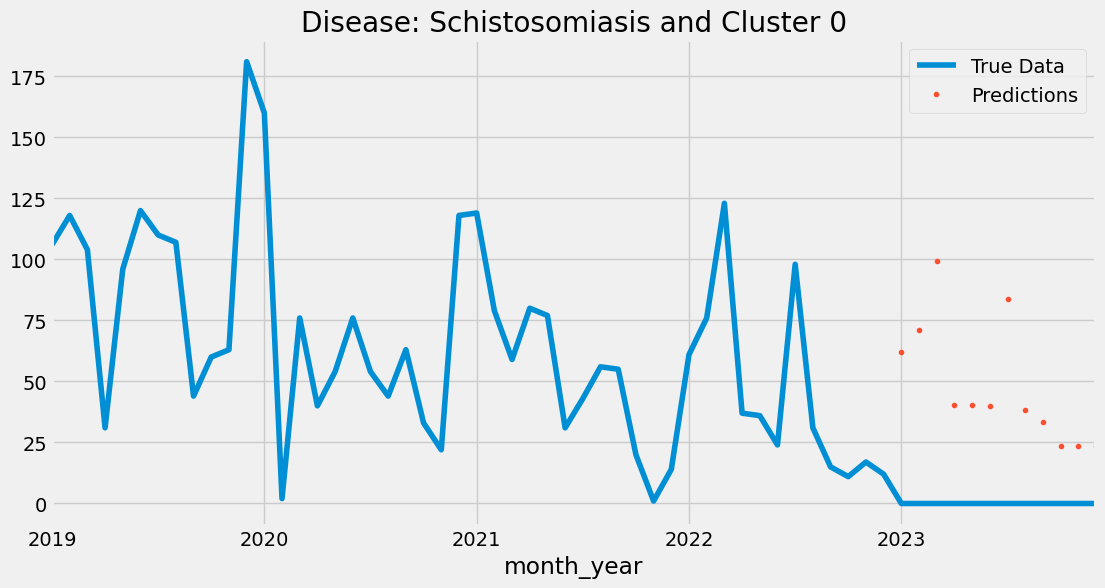

(360,)

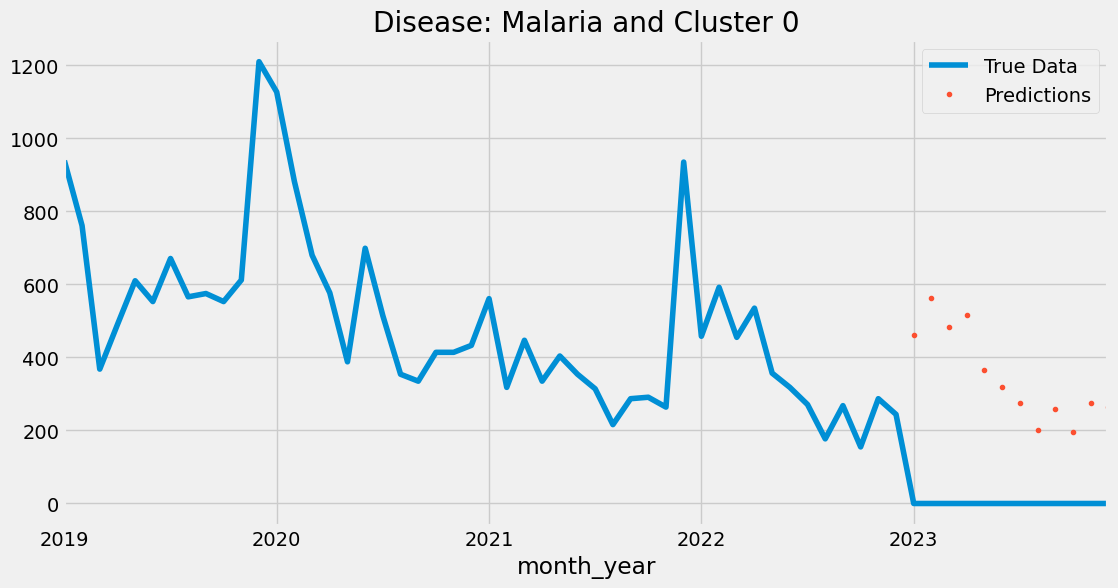

(360,)

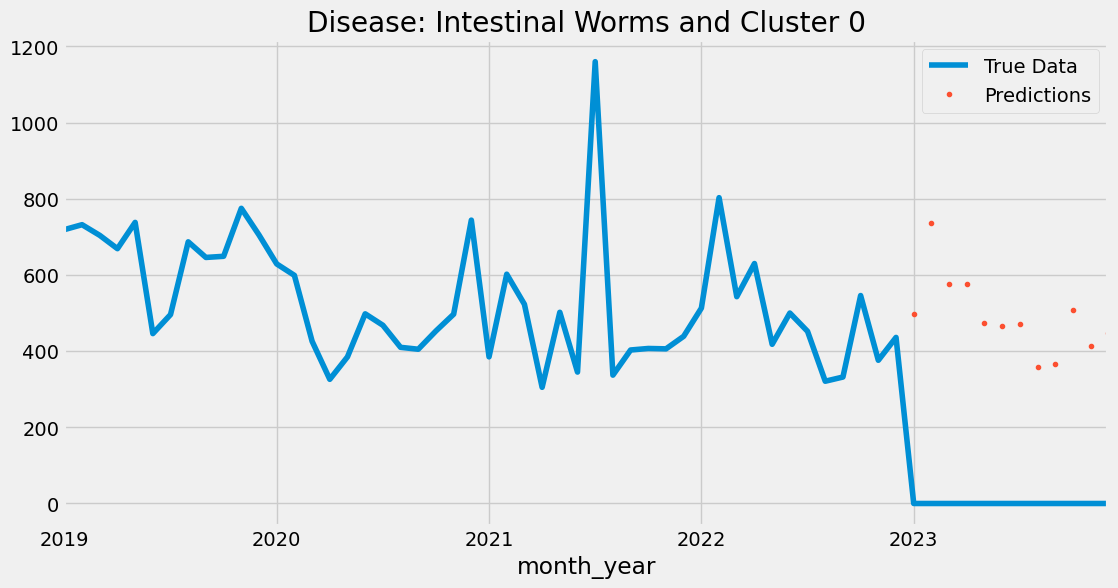

(360,)

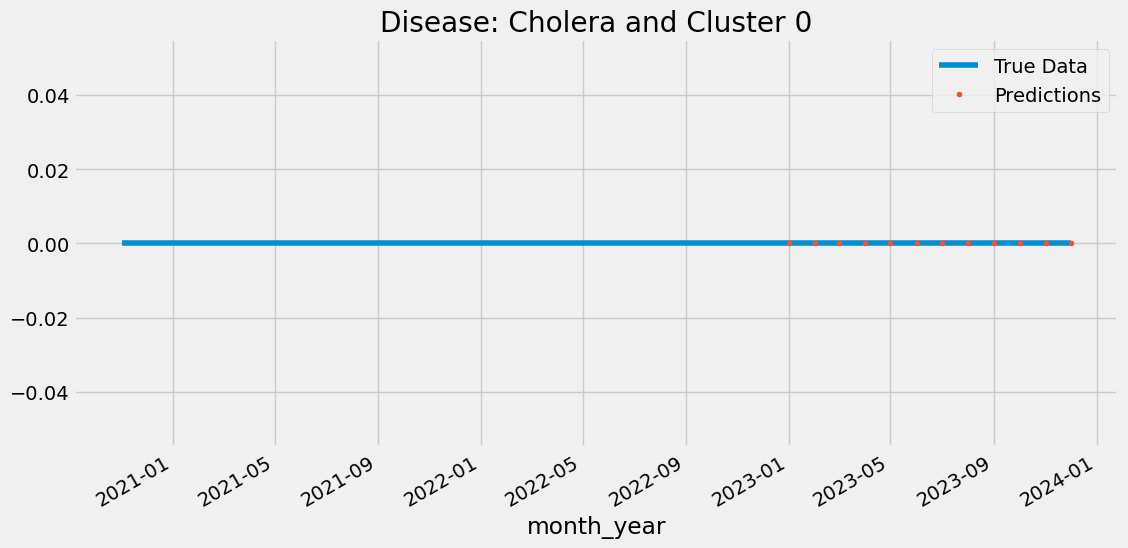

(60,)

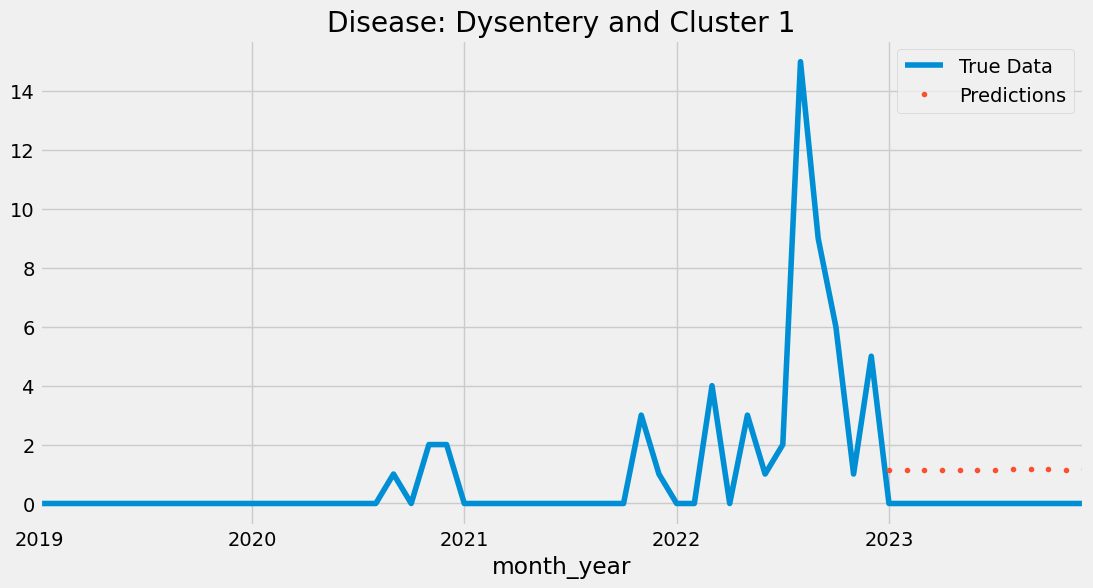

(60,)

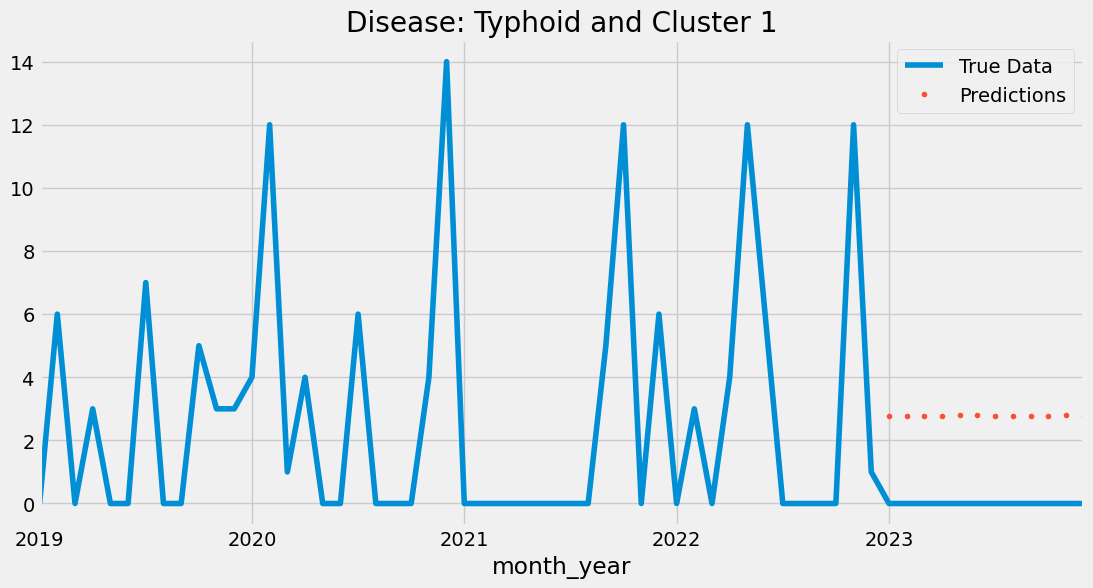

(60,)

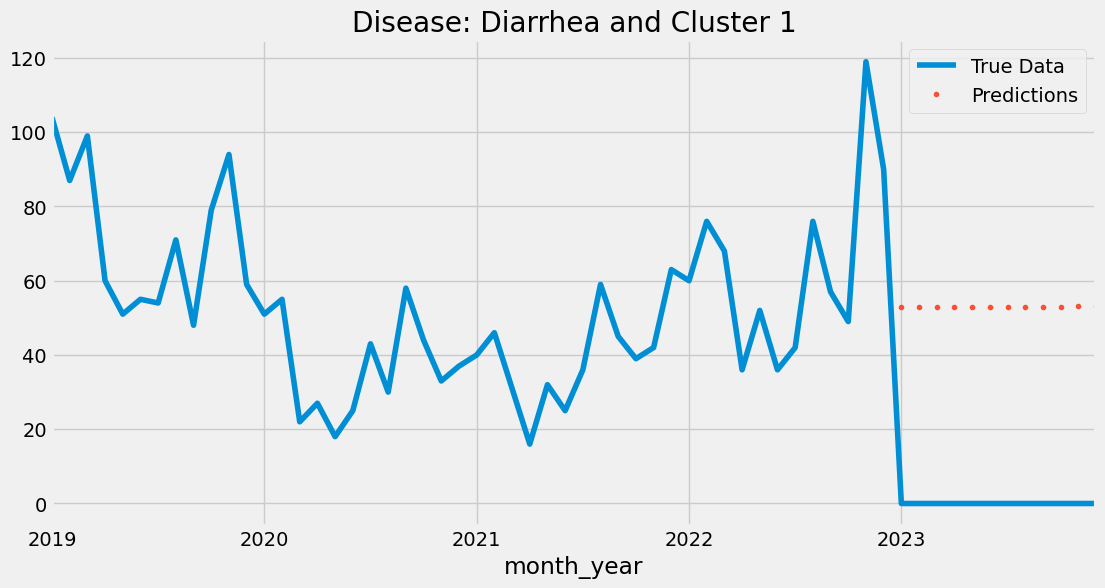

(60,)

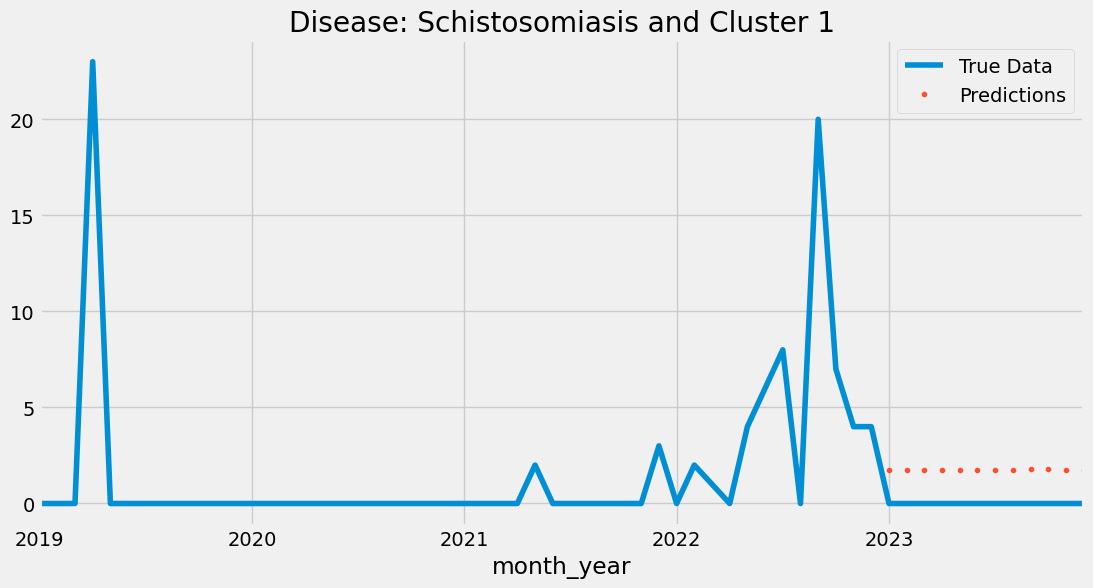

(60,)

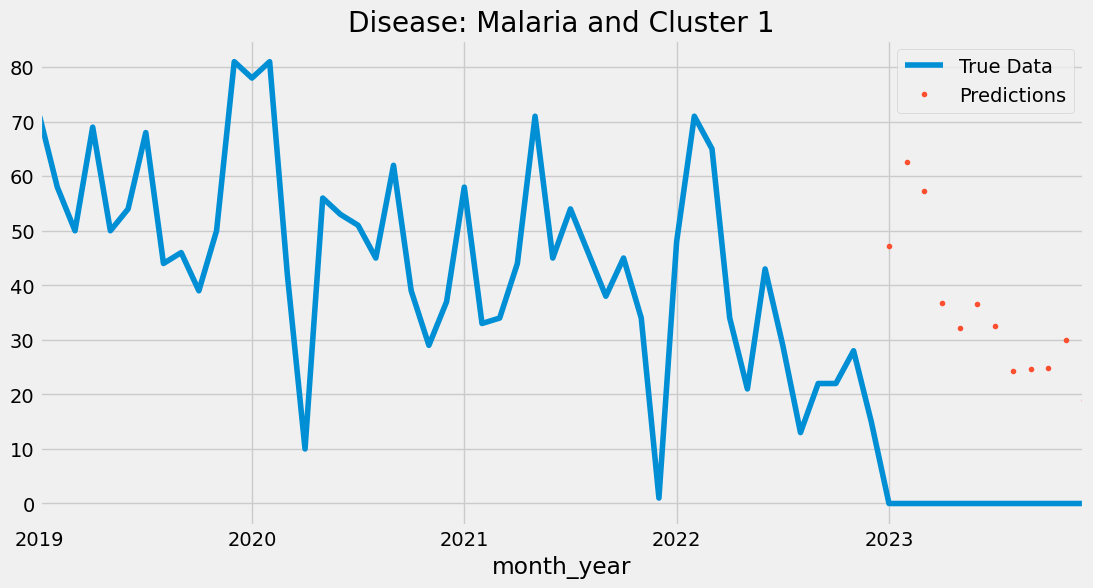

(60,)

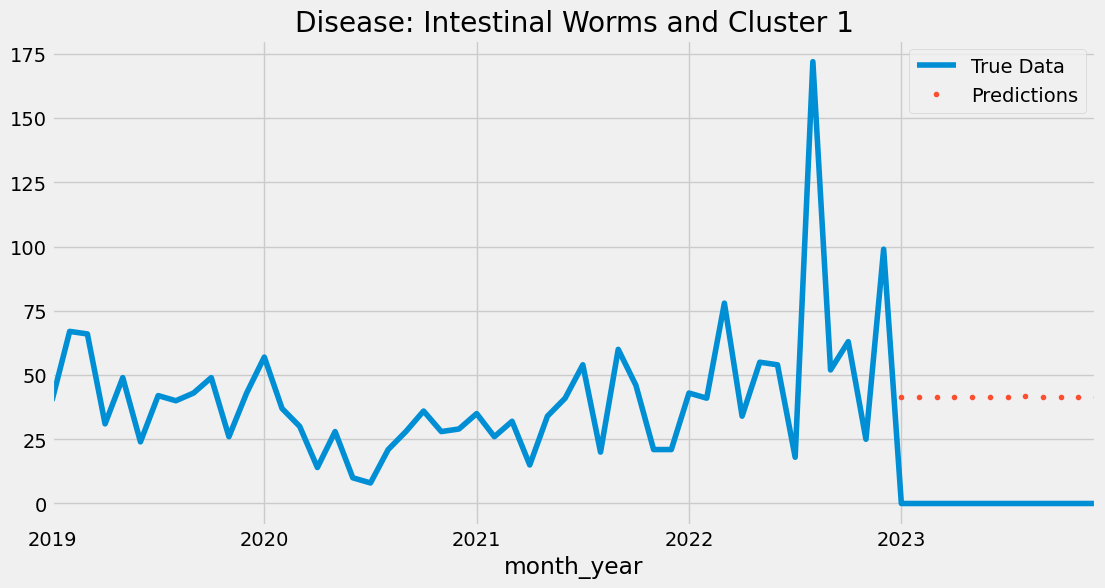

(60,)

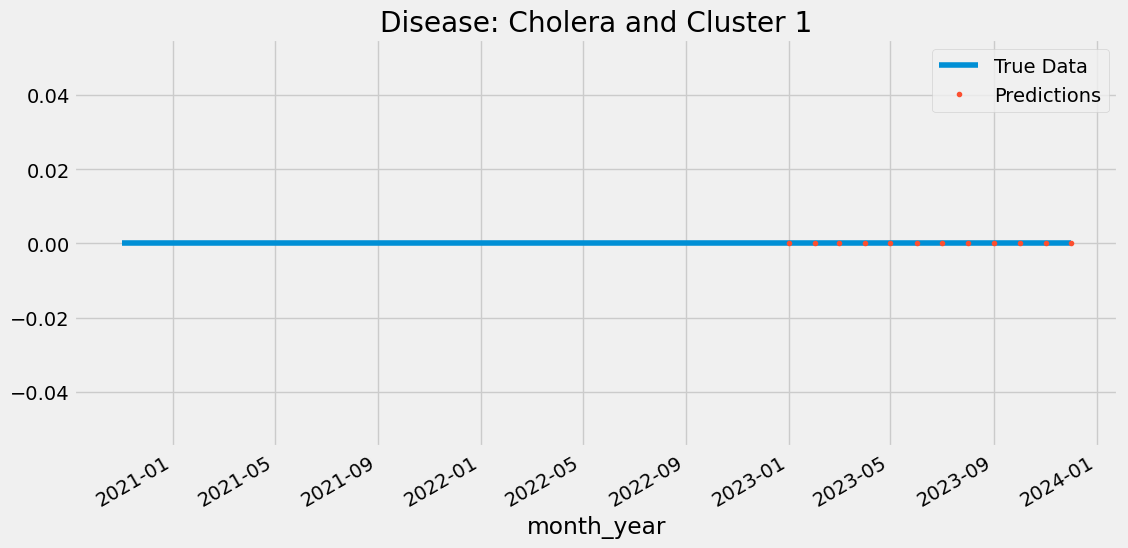

(60,)

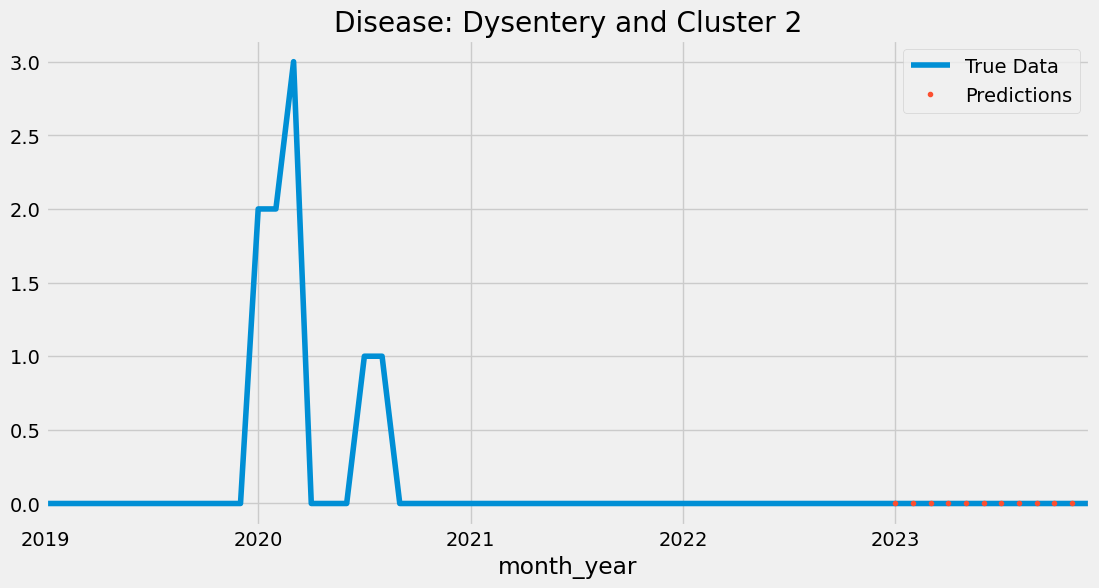

(60,)

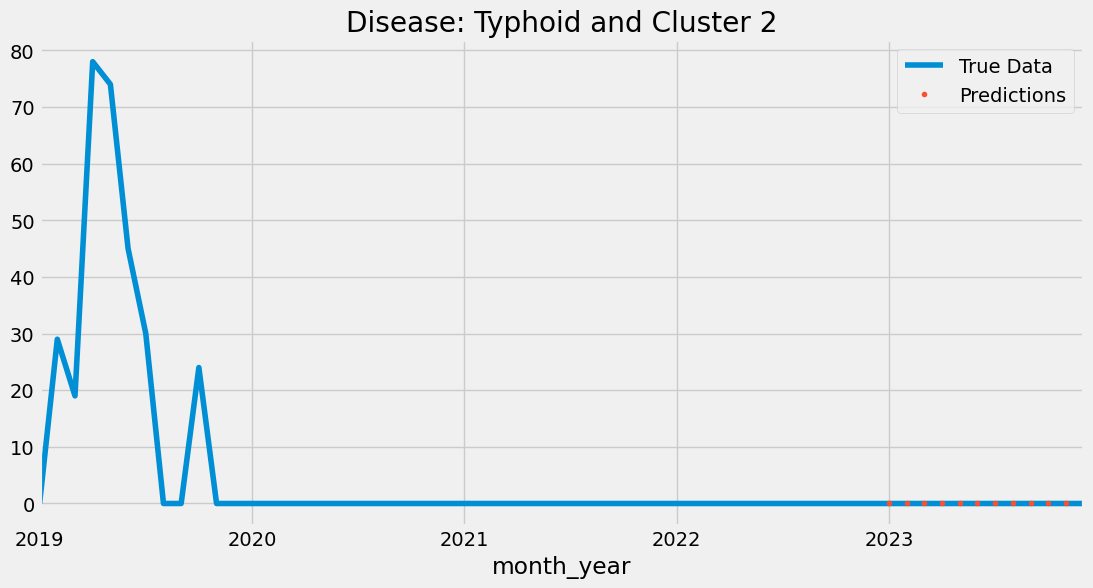

(60,)

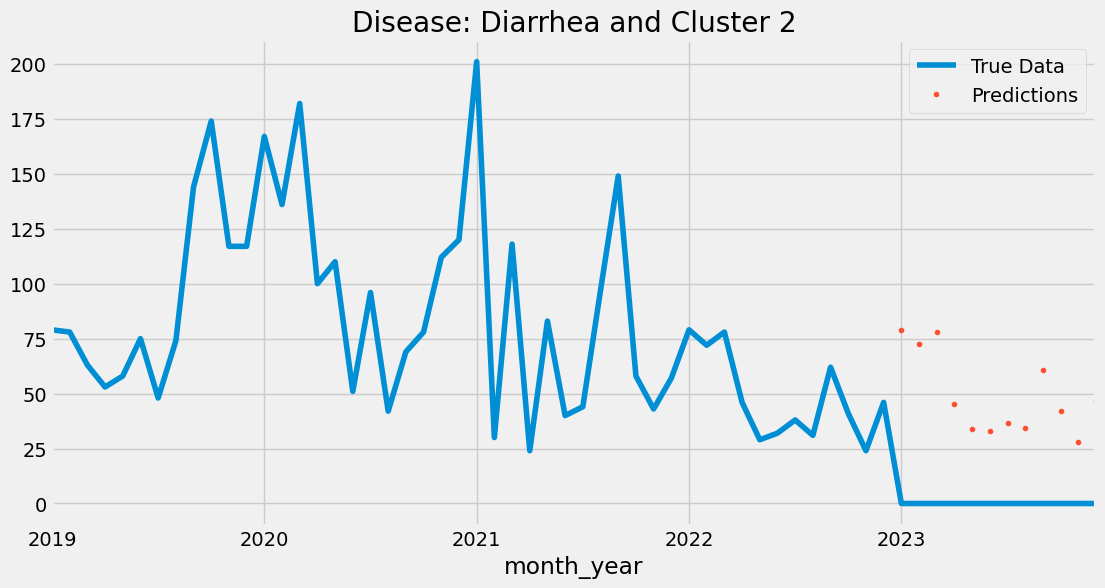

(60,)

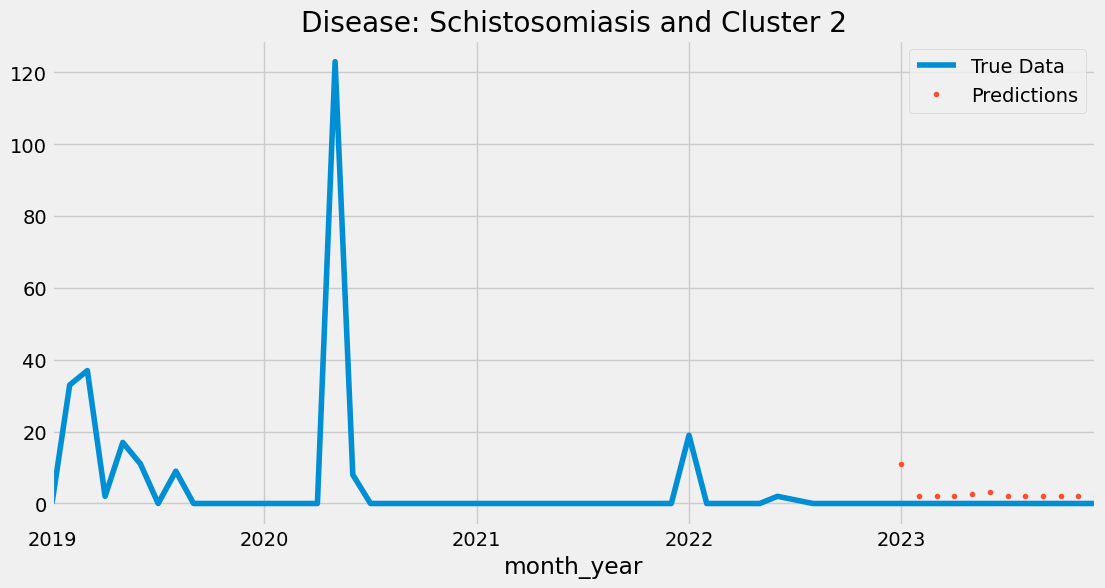

(60,)

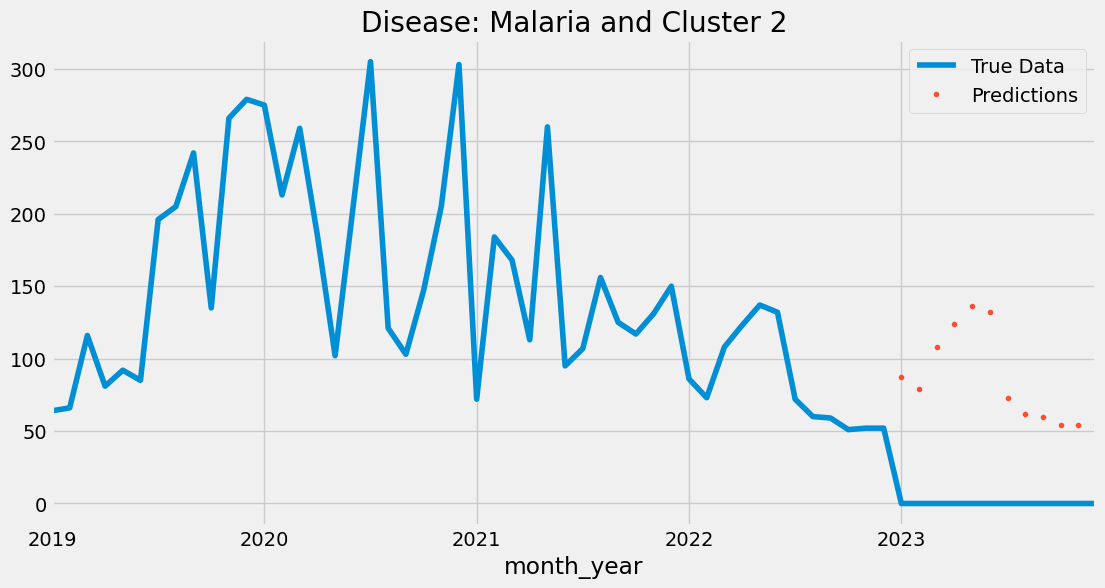

(60,)

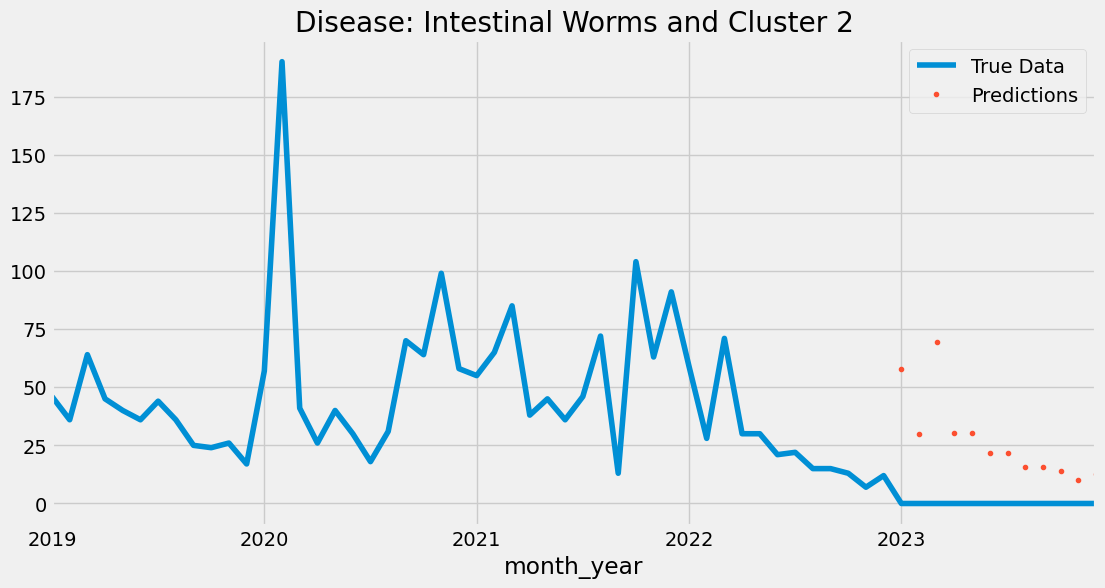

(60,)

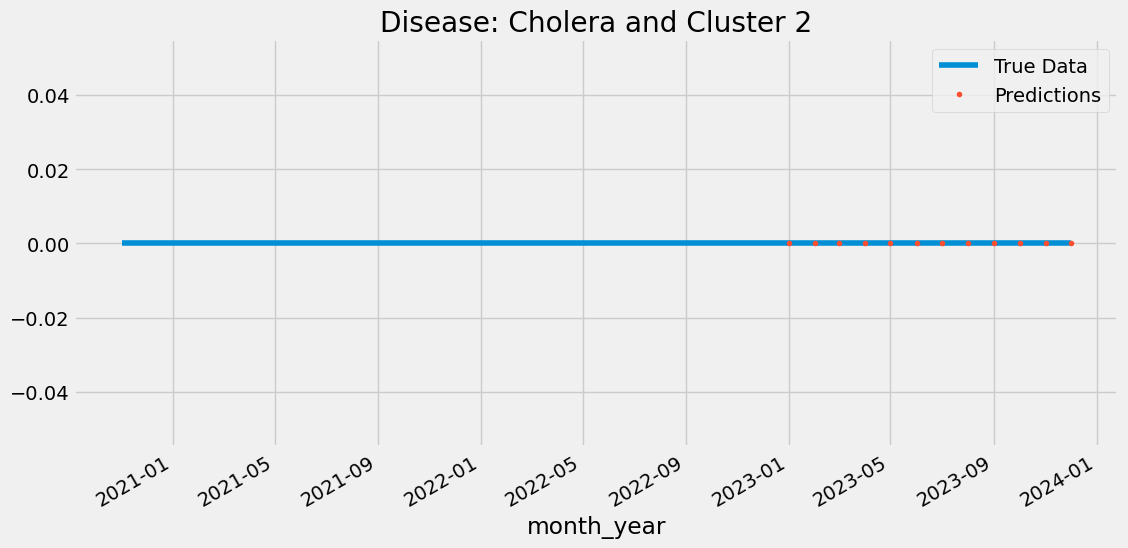

(48,)

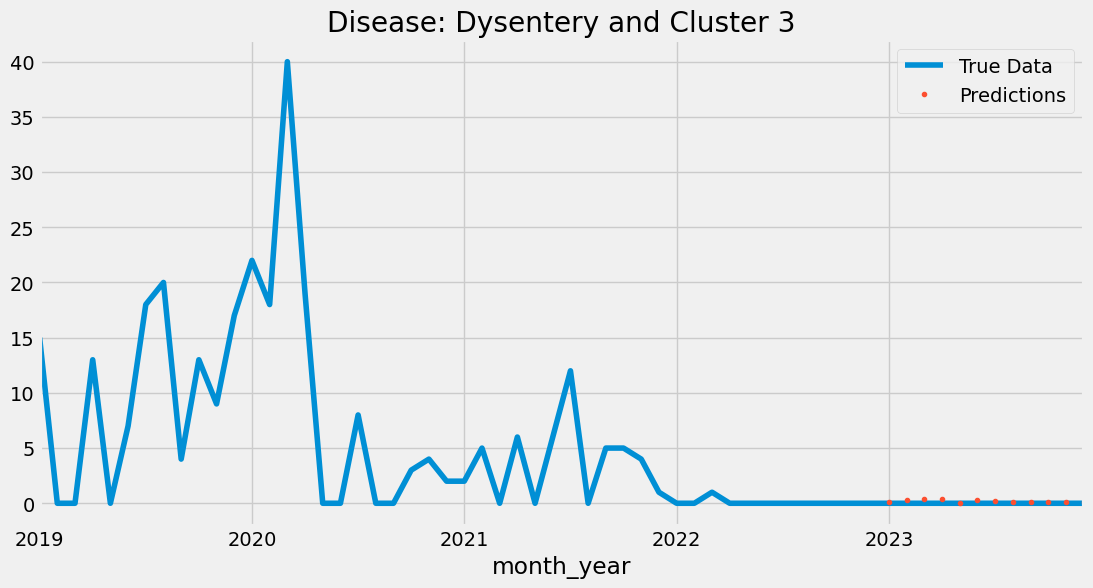

(48,)

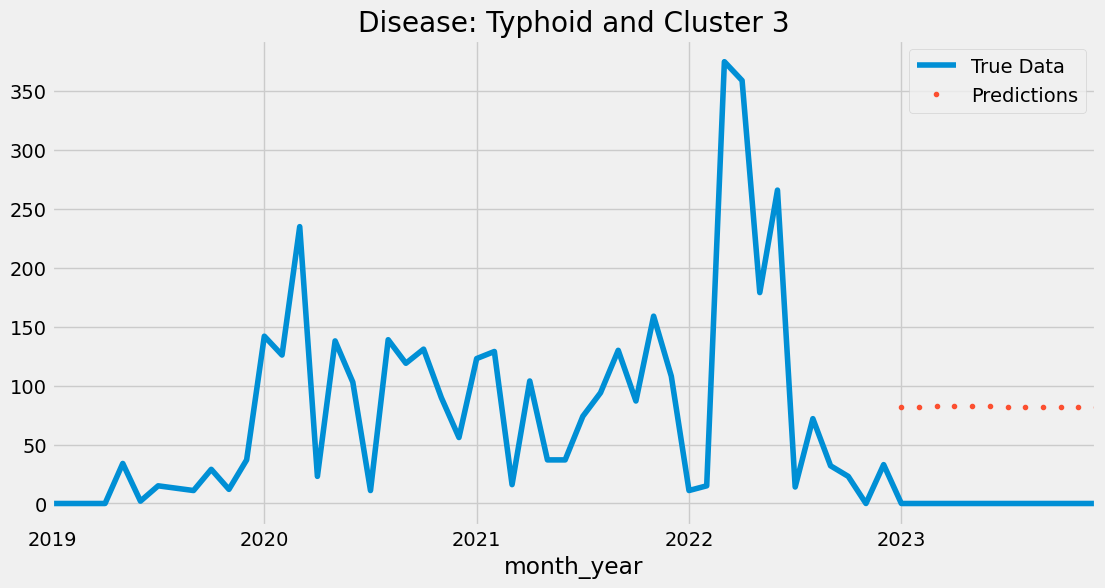

(48,)

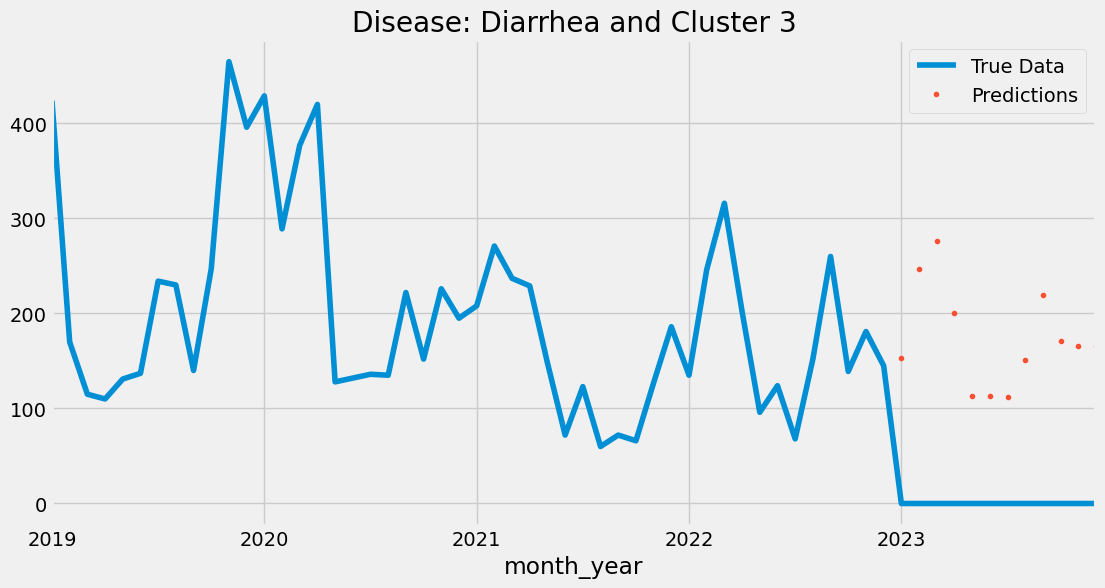

(48,)

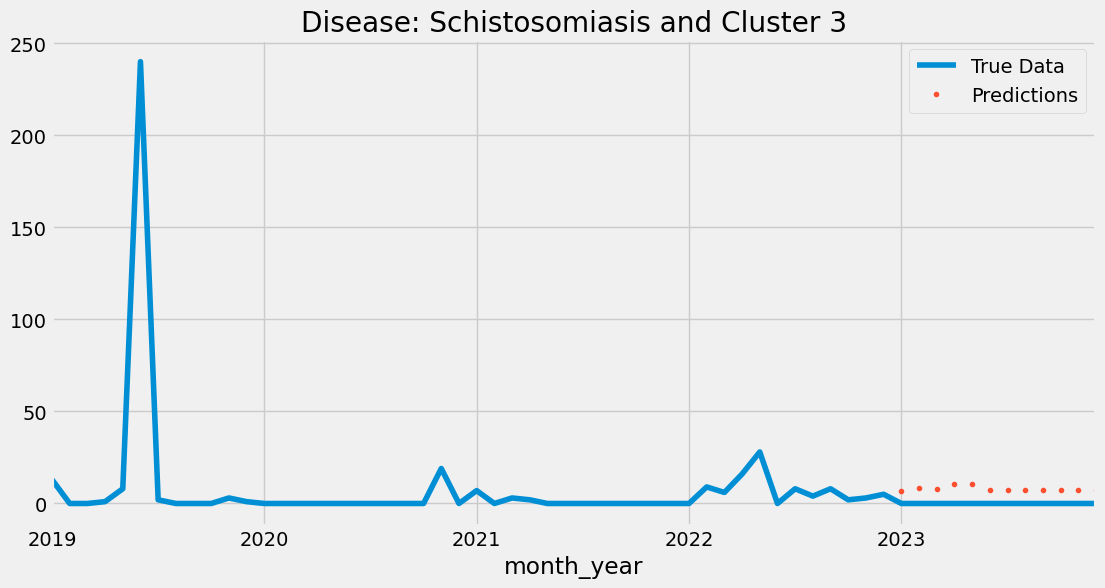

(48,)

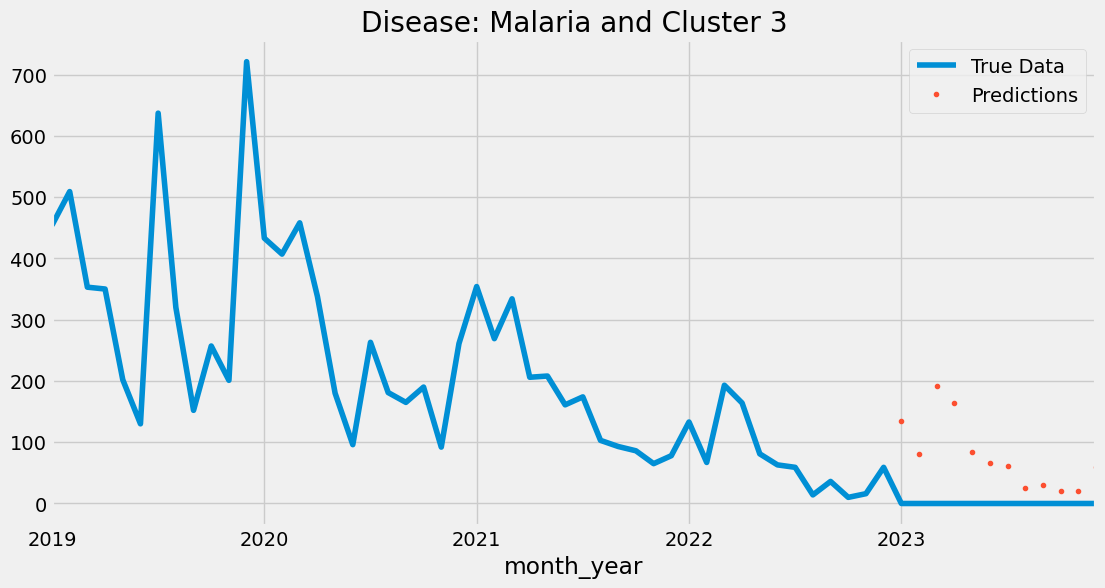

(48,)

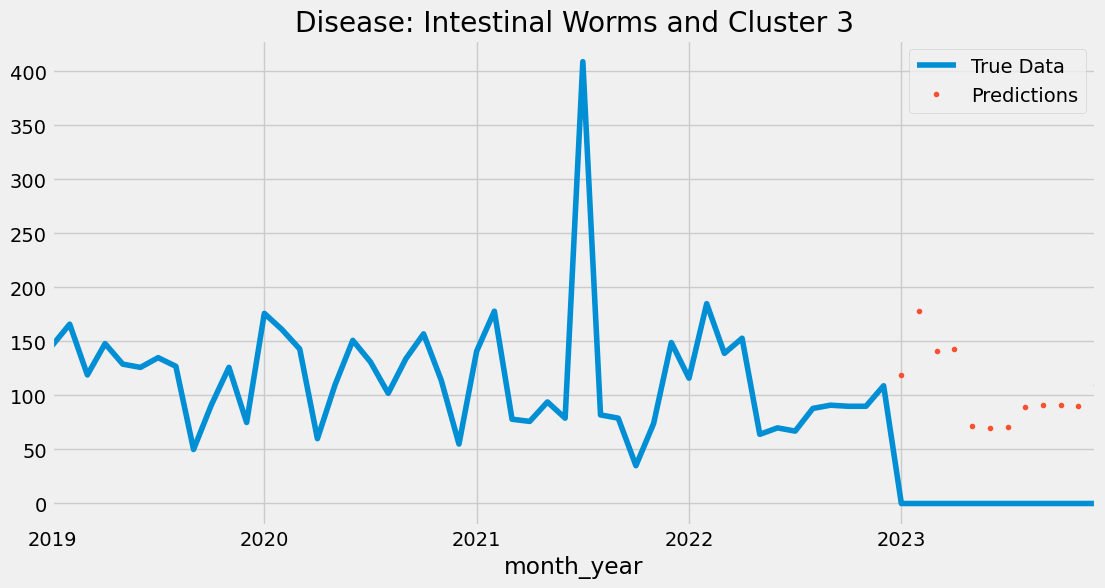

(48,)

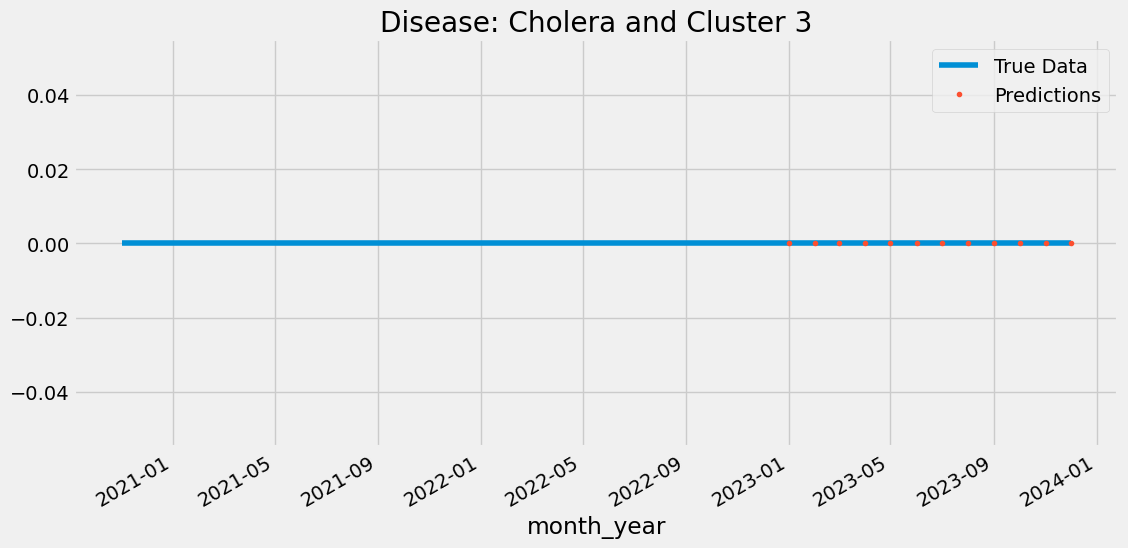

(180,)

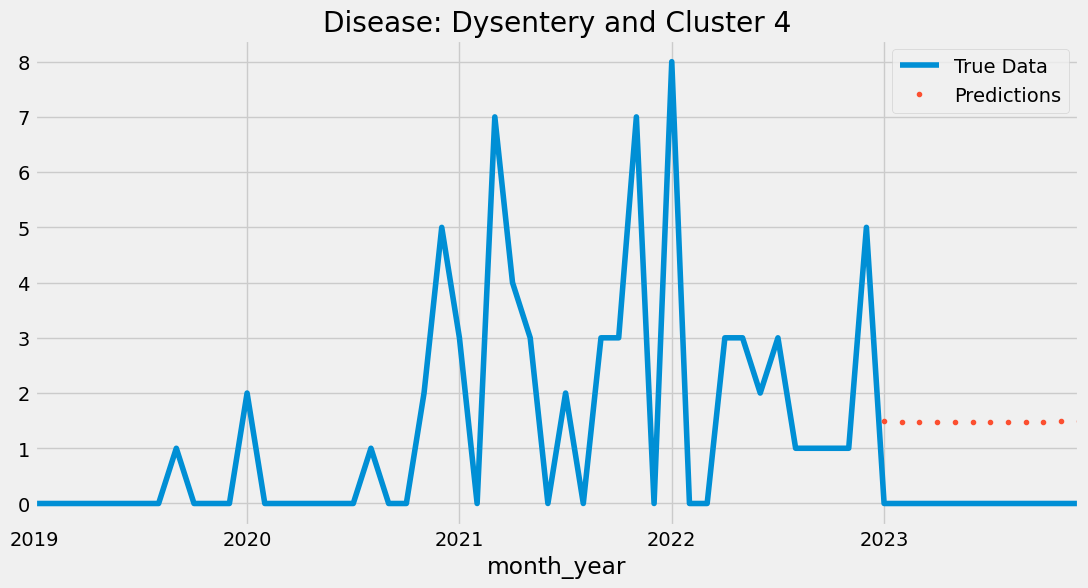

(180,)

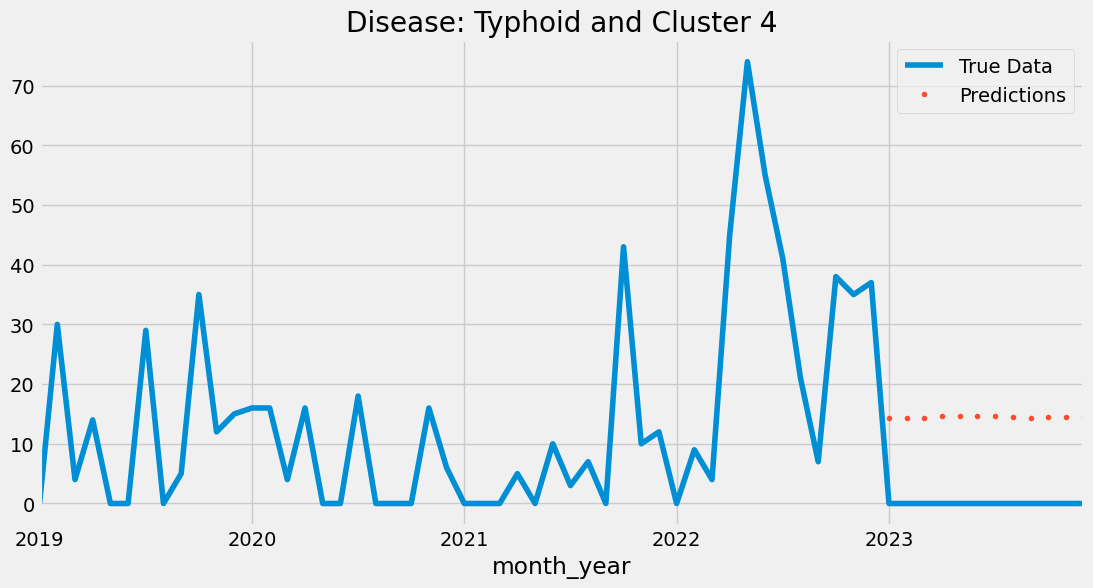

(180,)

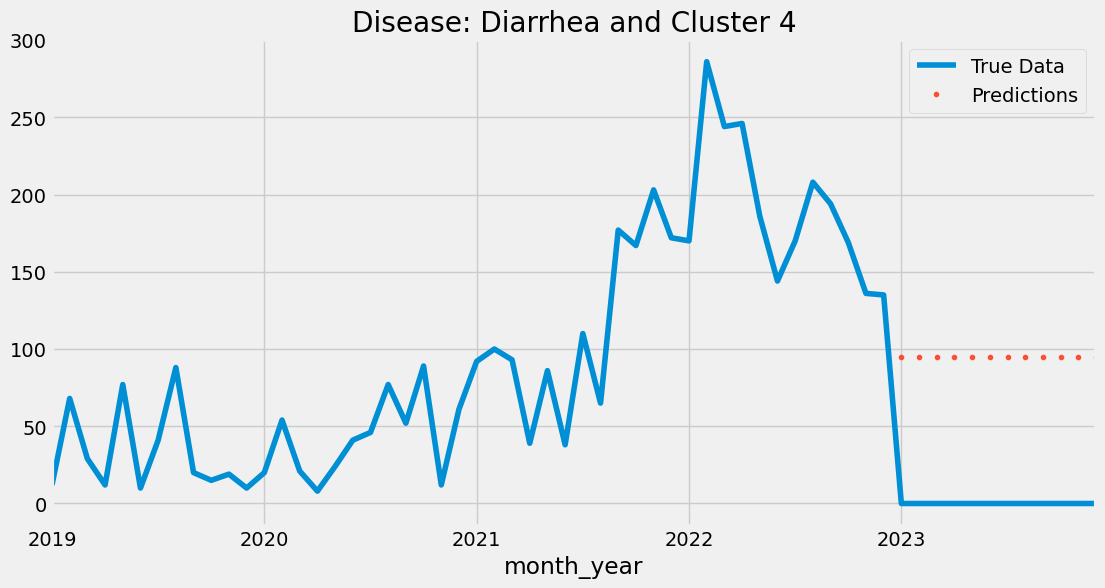

(180,)

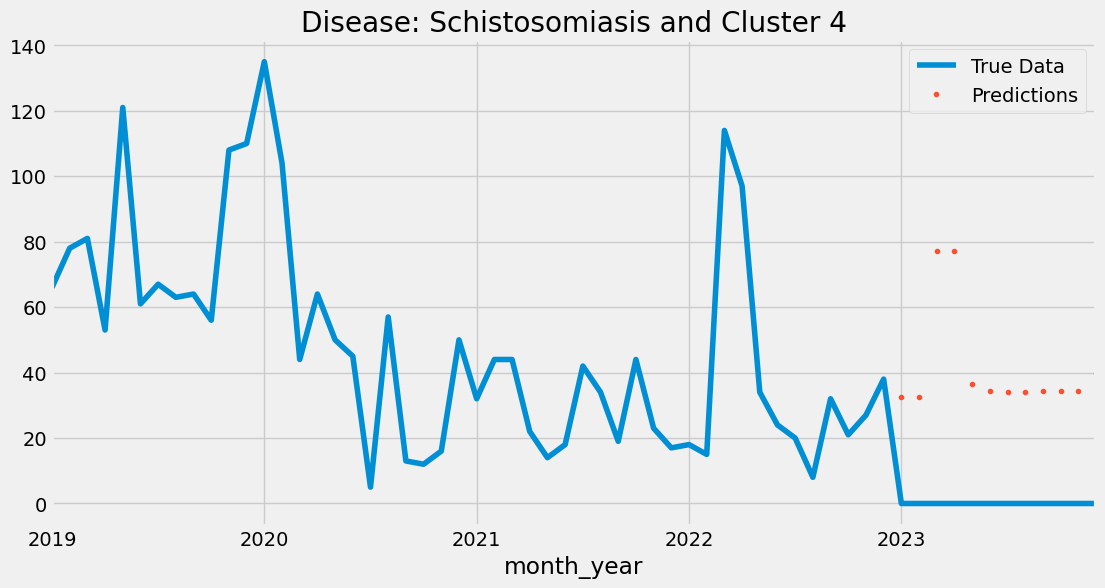

(180,)

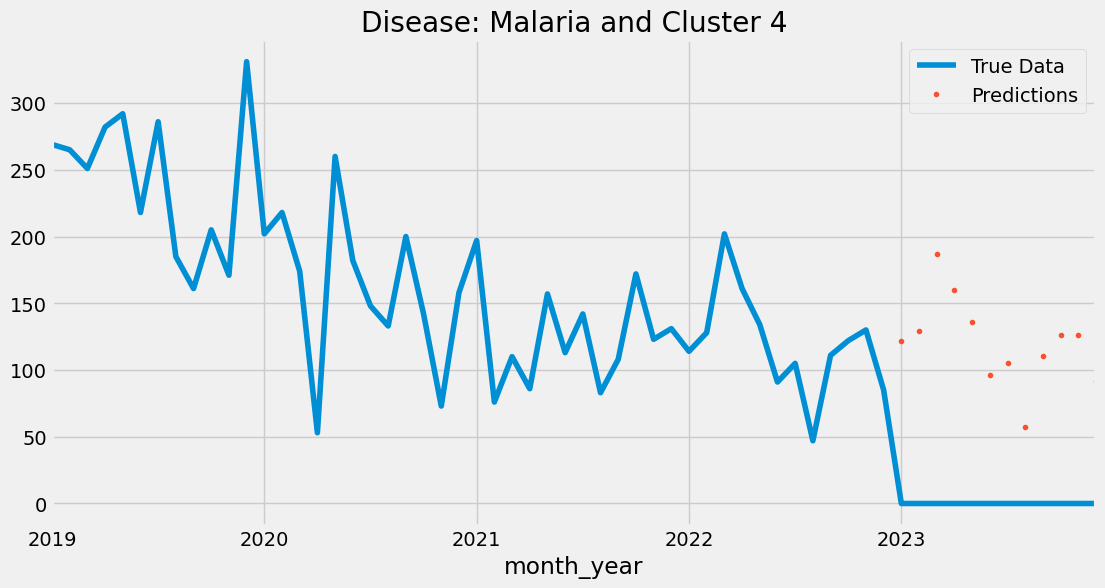

(180,)

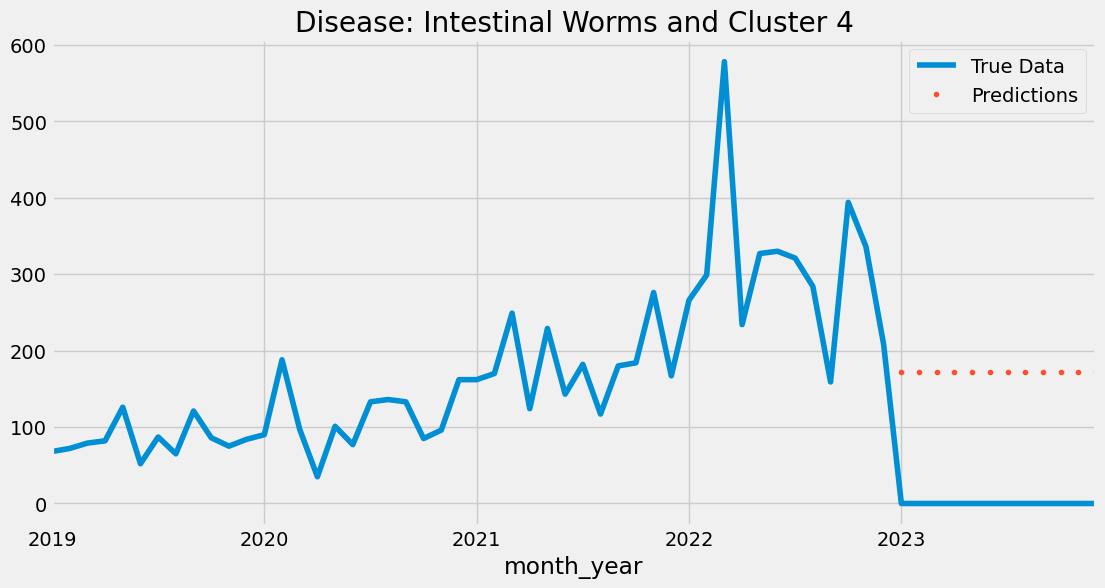

(180,)

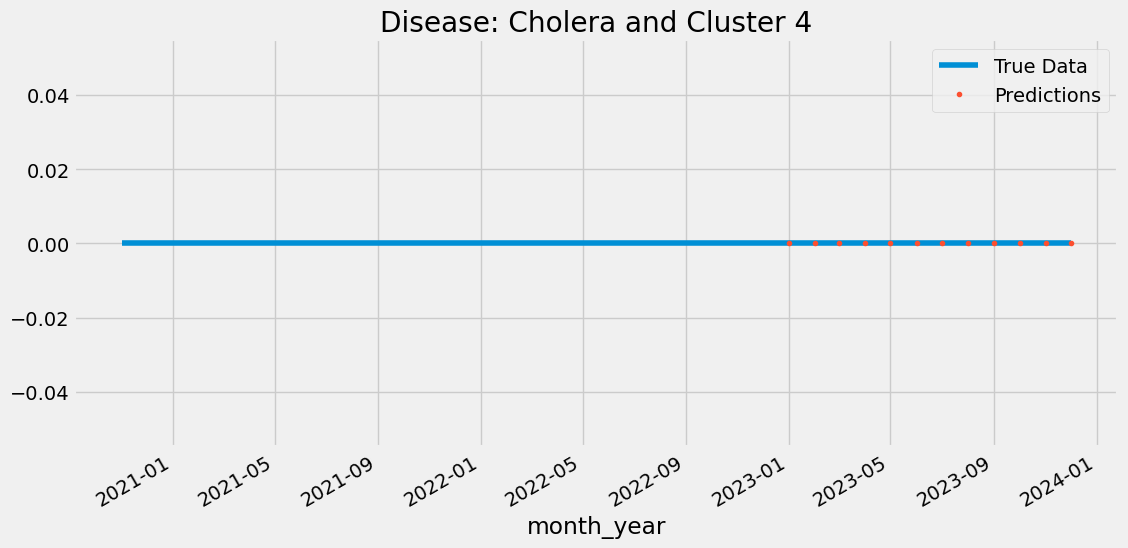

In [239]:
#pd.options.mode.copy_on_write = True 
def create_time_series_features(df):
    df = pd.DataFrame(df.copy())
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year
    return df

date_to_train = '01-01-2023'

FEATURES = ['month', 'quarter', 'year']

TARGET = ['Total']

for cluster_num in range(number_of_clusters):
    for disease_name in merged_data['Disease'].unique():
        disease_time_series = merged_data_trim_toilet[['month_year', 'Total']][(merged_data_trim_toilet['Disease']==disease_name)&(merged_data_trim_toilet['Location_Cluster']==cluster_num)].groupby(['month_year'])['Total'].sum().to_frame()

        #malaria_time_series = malaria_time_series.set_index('month_year')

        # malaria_time_series.plot(style='.', figsize=(15,5), color=color_pal[0], title='Malaria_time_series')

        

        train_series = disease_time_series.loc[disease_time_series.index< date_to_train]
        test_series = disease_time_series.loc[disease_time_series.index>= date_to_train]

        # fig, ax = plt.subplots(figsize=(15,5))
        # train_series.plot(ax=ax, label='Training Set')
        # test_series.plot(ax=ax, label='Test Set')
        # ax.axvline(date_to_train, color='black', ls='--')
        # plt.show()

        train_series = create_time_series_features(train_series)
        test_series = create_time_series_features(test_series)

        # fig, ax = plt.subplots(figsize=(8,6))
        # sns.boxplot(data=train_series, x='month', y='Total')

        # fig, ax = plt.subplots(figsize=(8, 6))
        # sns.boxplot(data=train_series, x='quarter', y='Total')

        X_train_series = train_series[FEATURES]
        y_train_series = train_series[TARGET]


        X_test_series = test_series[FEATURES]
        y_test_series = test_series[TARGET]

        reg = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.005, early_stopping_rounds=40)
        reg.fit(X_train_series, y_train_series, 
                eval_set=[(X_train_series, y_train_series), (X_test_series, y_test_series)],
                verbose=False)


        test_series['predictions'] = reg.predict(X_test_series)
        disease_time_series = disease_time_series.merge(test_series[['predictions']], how='left', left_index=True, right_index=True)
        month_year_from_slice = merged_data_trim_toilet[(merged_data_trim_toilet['Disease']==disease_name)&(merged_data_trim_toilet['month_year']>=date_to_train)&(merged_data_trim_toilet['Location_Cluster']==cluster_num)].copy()
        def get_total(row):
            date_from_slice = row['month_year']
            value_of_prediction = test_series['predictions'] .loc[date_from_slice]
            
            return value_of_prediction

        New_df = month_year_from_slice.apply(lambda row: get_total(row), axis=1)
        display(New_df.shape)
        # merged_data_trim_toilet.loc[(merged_data_trim_toilet['Disease']==disease_name)&(merged_data_trim_toilet['month_year']>=date_to_train)&(merged_data_trim_toilet['Location_Cluster']==cluster_num), 'Total_per_cluster_same_year_month']=New_df
        # display(merged_data_trim_toilet.loc[(merged_data_trim_toilet['Disease']==disease_name)&(merged_data_trim_toilet['month_year']>=date_to_train)&(merged_data_trim_toilet['Location_Cluster']==cluster_num), 'Total_per_cluster_same_year_month'].shape,
        # test_series['predictions'])


        #fig, ax = plt.subplots(figsize=(12,6))
        ax= disease_time_series[['Total']].plot(figsize=(12,6))
        disease_time_series['predictions'].plot(ax=ax, style='.')
        plt.legend(['True Data', 'Predictions'])
        ax.set_title(f'Disease: {disease_name} and Cluster {cluster_num}')
        plt.show()

In [240]:
merged_data_trim_toilet['Total_per_cluster_same_year_month'][merged_data_trim_toilet['Year']==2023].unique()

array([0.])

In [241]:
# fi = pd.DataFrame(data=reg.feature_importances_,
#              index=reg.feature_names_in_, 
#               columns=['importance'] )

In [242]:
# fi.sort_values('importance').plot(kind='barh', title='Feature Importance')

In [243]:
merged_data['Location_Cluster'].unique()

array([0, 4, 2, 1, 3])

<AxesSubplot:>

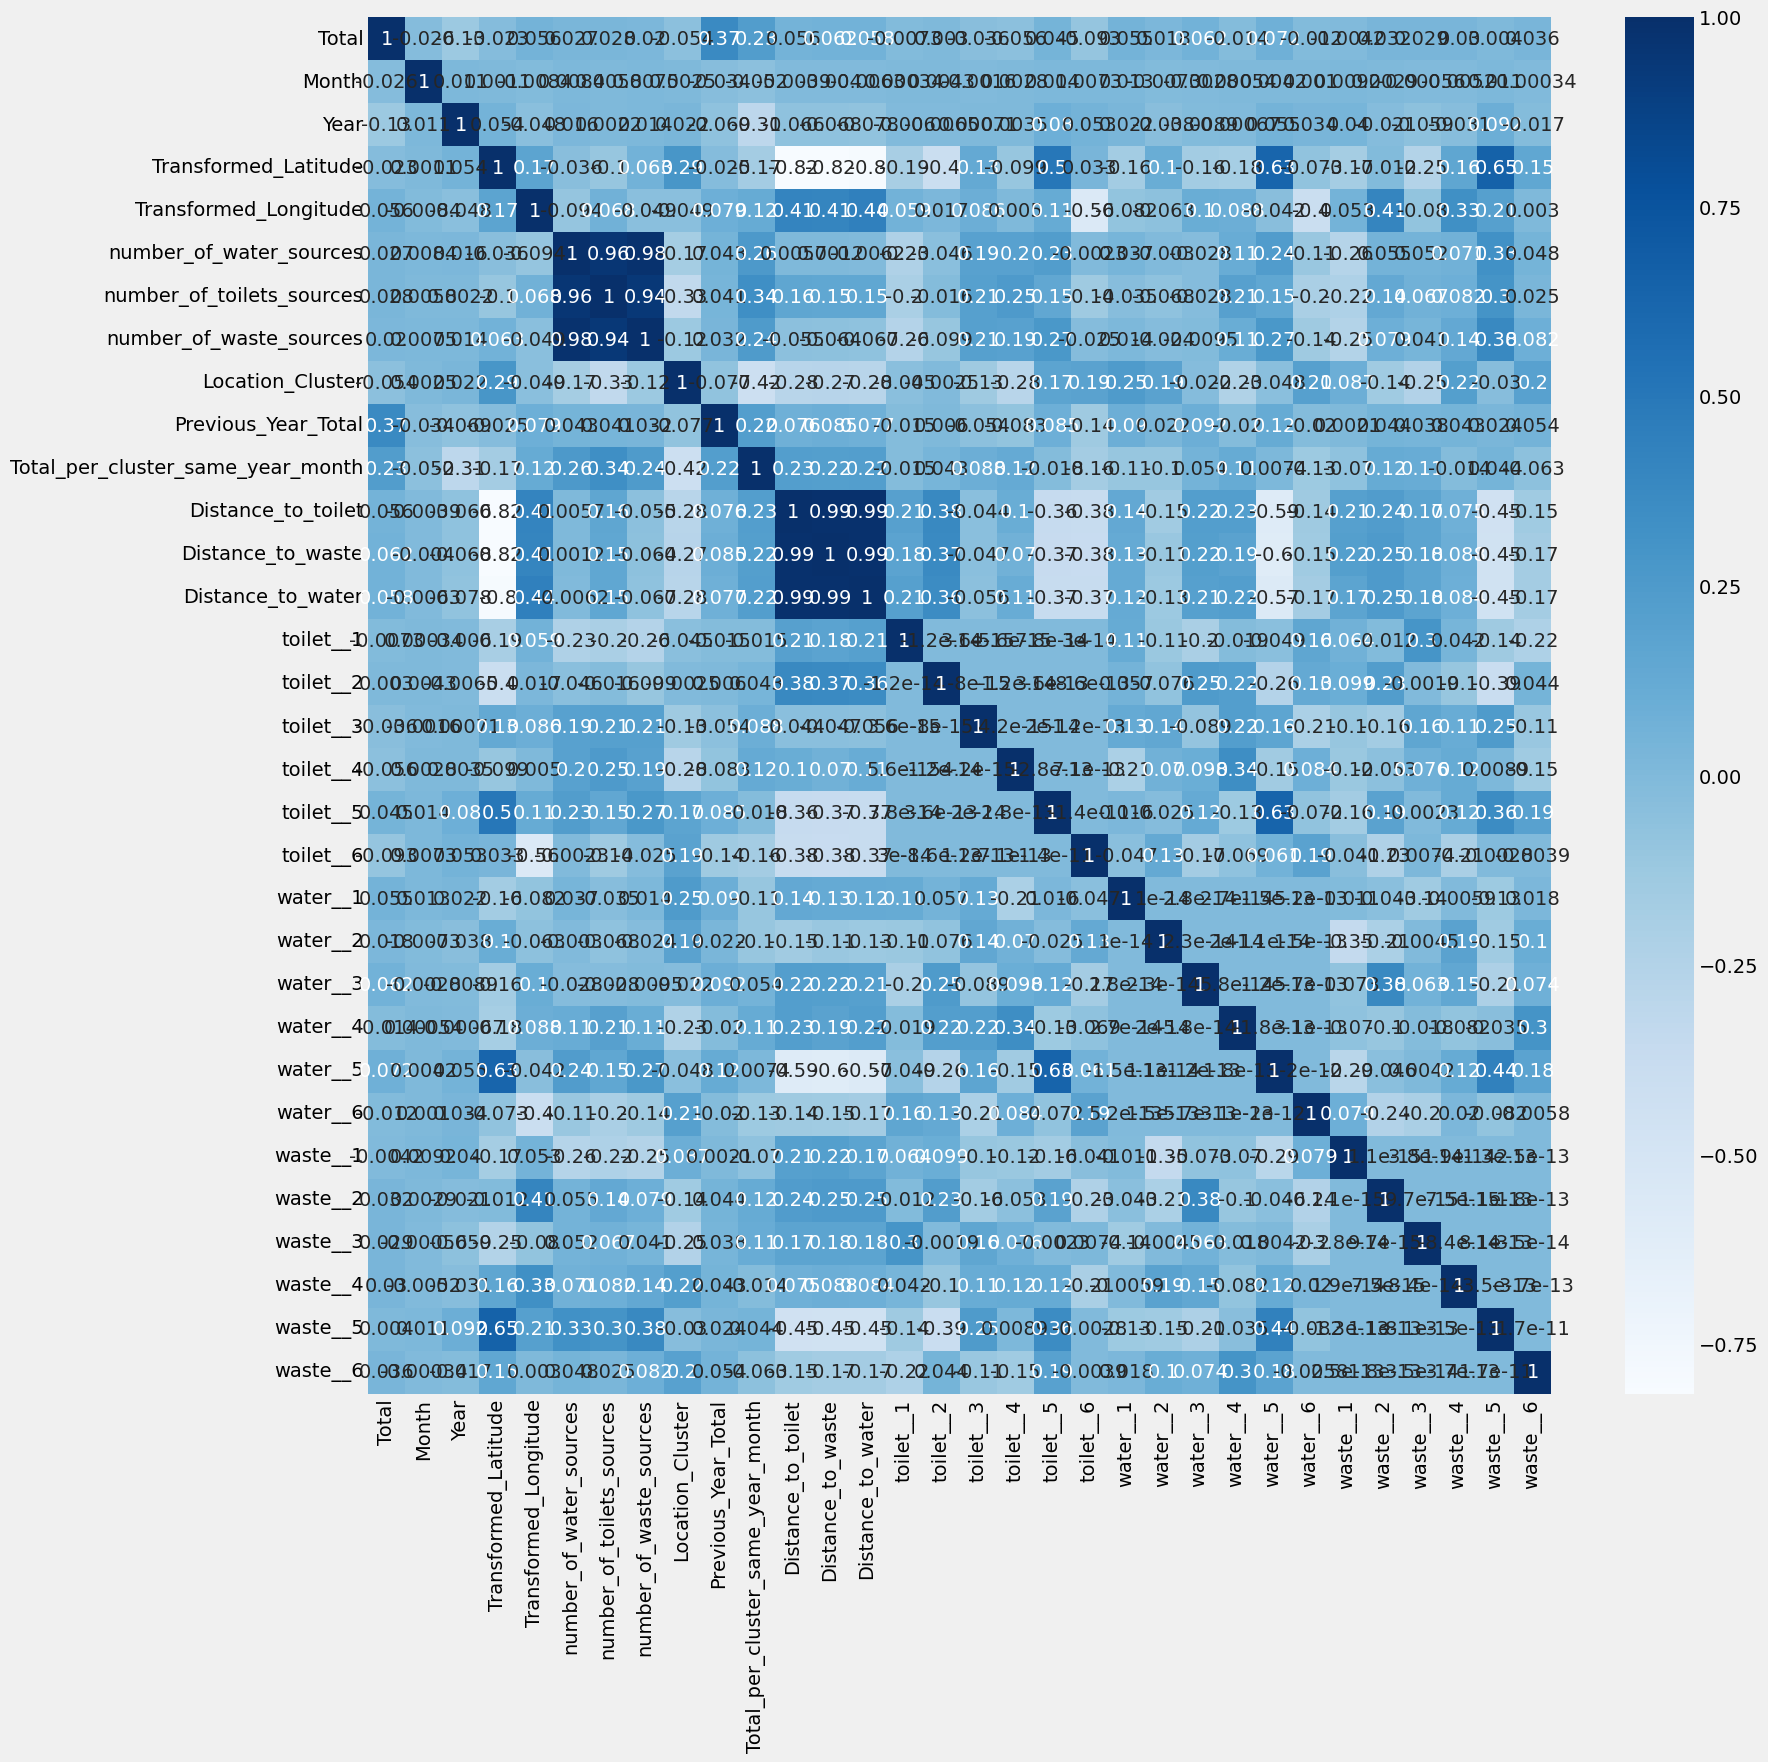

In [244]:
merged_data_trim_toilet_corr = merged_data_trim_toilet.corr()
fig = plt.figure(figsize= (17,17))

sns.heatmap(merged_data_trim_toilet_corr, annot=True, cmap=plt.cm.Blues)

In [245]:
for col in merged_data_trim_toilet.columns:
    print(col)

ID
Total
Location
Category_Health_Facility_UUID
Disease
Month
Year
Transformed_Latitude
Transformed_Longitude
toilet_Month_Year_lat_lon
toilet_Month_Year
lat_lon_x
Month_Year_lat_lon_x
waste_Month_Year_lat_lon
waste_Month_Year
lat_lon_y
Month_Year_lat_lon_y
water_Month_Year_lat_lon
water_Month_Year
lat_lon
Month_Year_lat_lon
number_of_water_sources
number_of_toilets_sources
number_of_waste_sources
Location_Cluster
Previous_Year_Total
Total_per_cluster_same_year_month
Distance_to_toilet
Distance_to_waste
Distance_to_water
toilet__1
toilet__2
toilet__3
toilet__4
toilet__5
toilet__6
water__1
water__2
water__3
water__4
water__5
water__6
waste__1
waste__2
waste__3
waste__4
waste__5
waste__6
month_year


In [246]:
col_to_drop = ['lat_lon_x', 'waste_Month_Year_lat_lon', 'waste_Month_Year', 'lat_lon_x', 'water_Month_Year_lat_lon', 'Month_Year_lat_lon_x', 'lat_lon_y', 'toilet_Month_Year','toilet_Month_Year_lat_lon', 'lat_lon', 'water_Month_Year']

merged_data_trim_toilet = merged_data_trim_toilet.drop(col_to_drop, axis=1)

In [247]:
for col in merged_data_trim_toilet.columns:
    print(col)

ID
Total
Location
Category_Health_Facility_UUID
Disease
Month
Year
Transformed_Latitude
Transformed_Longitude
Month_Year_lat_lon_y
Month_Year_lat_lon
number_of_water_sources
number_of_toilets_sources
number_of_waste_sources
Location_Cluster
Previous_Year_Total
Total_per_cluster_same_year_month
Distance_to_toilet
Distance_to_waste
Distance_to_water
toilet__1
toilet__2
toilet__3
toilet__4
toilet__5
toilet__6
water__1
water__2
water__3
water__4
water__5
water__6
waste__1
waste__2
waste__3
waste__4
waste__5
waste__6
month_year


In [248]:
# for col in merged_data['Disease'].unique():
#     data = merged_data[merged_data['Disease']==col]

#     print(data['Total'])
#     print(data['month_year'])
#     break



In [249]:
# for col in merged_data_trim_toilet.columns:
#     print(col)

In [250]:
merged_data_trim_toilet.shape

(29331, 39)

## Start modeling

In [251]:
merged_data_trim_toilet = merged_data_trim_toilet.drop(['month_year', 'Month_Year_lat_lon'], axis=1)

In [252]:
# Split merged data into train and test sets
train_df = merged_data_trim_toilet[merged_data_trim_toilet['Year'] < 2023]
test_df = merged_data_trim_toilet[merged_data_trim_toilet['Year'] == 2023]

In [253]:
# Specify the target column
target_column = 'Total'

# Feature and target split
X = train_df.drop(columns=[target_column, 'ID', 'Location'])  # Exclude unnecessary columns
y = train_df[target_column]

In [254]:
# categorical_cols = X.select_dtypes(include=['object']).columns
# numerical_col = X.select_dtypes(include=['float', 'int']).columns
# preprocessor = make_column_transformer((LabelEncoder(), categorical_cols), (StandardScaler(), numerical_col))
# X = preprocessor.fit_transform(X)

In [255]:
#numerical_col = X.select_dtypes(include=['float', 'int']).columns
for col in numerical_col:
    scaler = MinMaxScaler()
    X[col] = scaler.fit_transform(X[[col]])

In [256]:
# Handle categorical features
categorical_cols = X.select_dtypes(include=['object']).columns
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])


In [257]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RSEED)

In [258]:
# Initialize and train the regression model
from lightgbm import LGBMRegressor
#model = RandomForestRegressor(random_state=42)
model = LGBMRegressor(random_state=RSEED)
model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1551
[LightGBM] [Info] Number of data points in the train set: 19500, number of used features: 34
[LightGBM] [Info] Start training from score 8.234256


LGBMRegressor(random_state=34)

<AxesSubplot:title={'center':'Feature Importance'}>

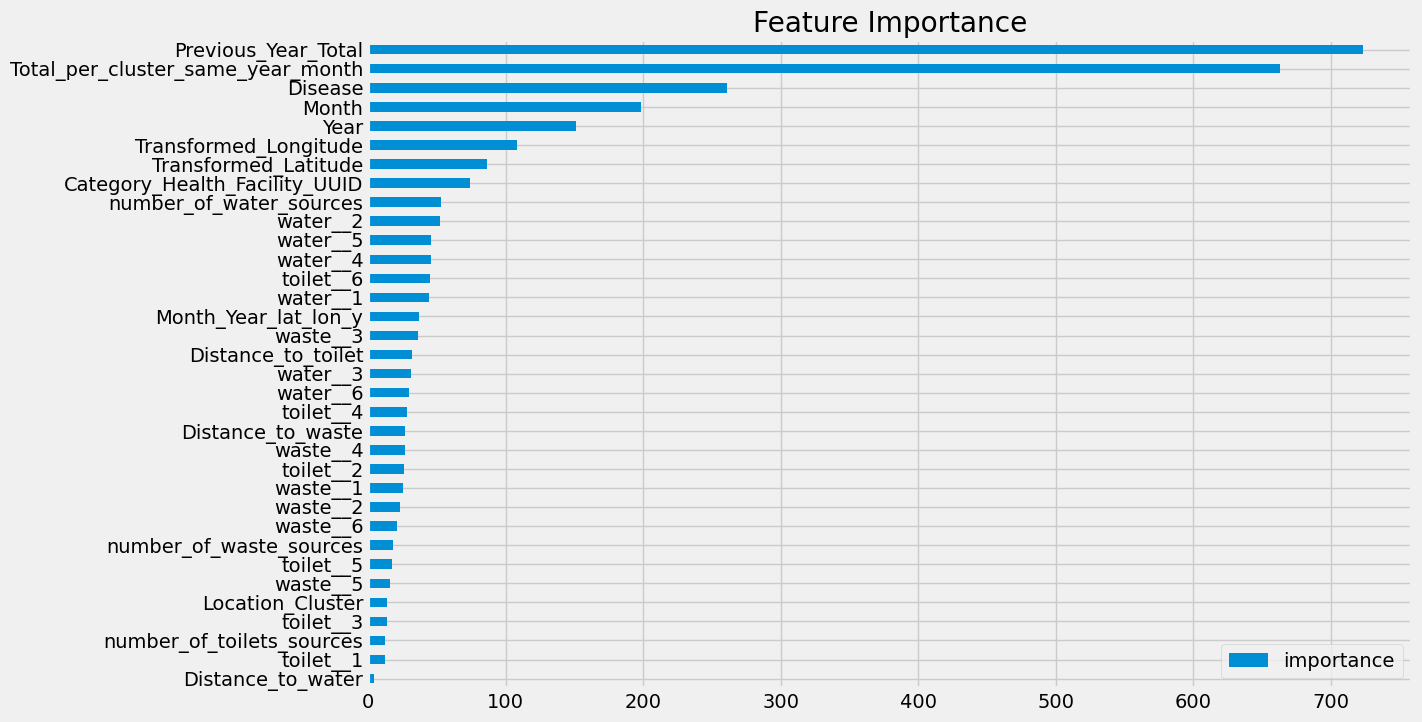

In [259]:
fi = pd.DataFrame(data=model.feature_importances_,
             index=model.feature_names_in_, 
              columns=['importance'] )
fig, ax = plt.subplots(figsize=(12,8))
fi.sort_values('importance').plot(kind='barh', ax=ax, title='Feature Importance')

In [260]:
# Make predictions
y_pred = model.predict(X_test)
y_pred = list(map(lambda x: np.maximum(0,x), y_pred))

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE) lgb: {mae}")

Mean Absolute Error (MAE) lgb: 9.88109688807284


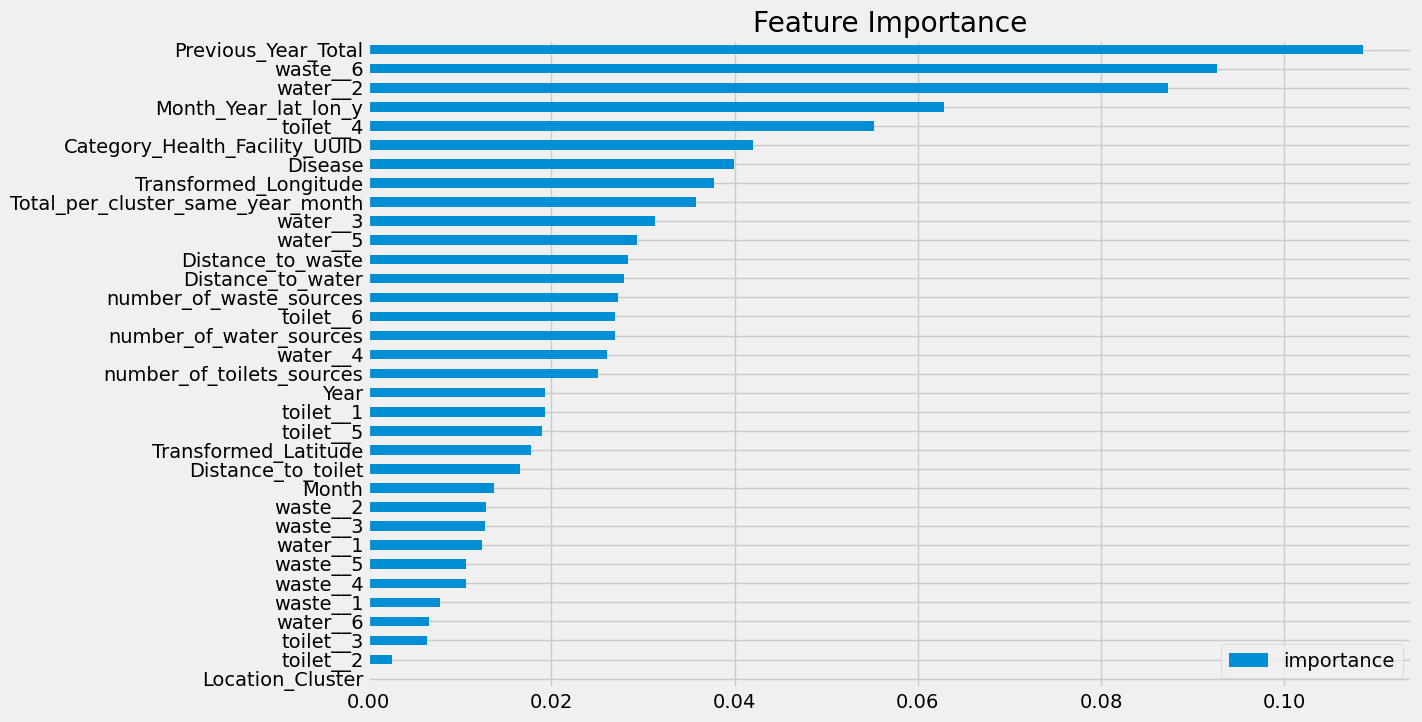

Mean Absolute Error (MAE) xgb: 10.71848309854972


In [261]:

xgb_model = xgb.XGBRFRegressor(random_state=RSEED)
xgb_model.fit(X_train, y_train)

fi = pd.DataFrame(data=xgb_model.feature_importances_,
             index=xgb_model.feature_names_in_, 
              columns=['importance'] )
fig, ax = plt.subplots(figsize=(12,8))
fi.sort_values('importance').plot(kind='barh', ax=ax, title='Feature Importance')
plt.show()
# Make predictions
y_pred = xgb_model.predict(X_test)
y_pred = list(map(lambda x: np.maximum(0,x), y_pred))

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE) xgb: {mae}")


In [262]:
model = LGBMRegressor(random_state=RSEED)
model.fit(X, y)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000749 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1554
[LightGBM] [Info] Number of data points in the train set: 24375, number of used features: 34
[LightGBM] [Info] Start training from score 8.356677


LGBMRegressor(random_state=34)

#### Make predictions on test

In [263]:
# Prepare test data
X_test_final = test_df.drop(columns=['Total', 'ID', 'Location'], errors='ignore')

In [264]:
# Handle categorical features in test data
for col in categorical_cols:
    if col in X_test_final.columns:
        le = LabelEncoder()
        X_test_final[col] = le.fit_transform(X_test_final[col])

In [265]:
# Align test dataset with training features
# for col in X.columns:
#     if col not in X_test_final.columns:
#         X_test_final[col] = 0  # Add missing feature with default value (e.g., zero)


In [266]:
# Ensure columns are in the same order as training
X_test_final = X_test_final[X.columns]

In [267]:
# Make predictions on test data
predictions = model.predict(X_test_final)

In [268]:

predictions = list(map(lambda x:  np.maximum(0,x), predictions))

In [269]:
# Create the final DataFrame with ID and predictions
sub = test_df[['ID']].copy()
sub['Predicted_Total'] = predictions

In [270]:
# View the first few records in sub
display(sub.head(10))

ID  Predicted_Total
528  ID_3a11929e-3317-476d-99f7-1bd9fb58f018_1_2023...              0.0
529  ID_3a11929e-3317-476d-99f7-1bd9fb58f018_2_2023...              0.0
530  ID_3a11929e-3317-476d-99f7-1bd9fb58f018_3_2023...              0.0
531  ID_3a11929e-3317-476d-99f7-1bd9fb58f018_4_2023...              0.0
532  ID_3a11929e-3317-476d-99f7-1bd9fb58f018_5_2023...              0.0
533  ID_3a11929e-3317-476d-99f7-1bd9fb58f018_6_2023...              0.0
534  ID_3a11929e-3317-476d-99f7-1bd9fb58f018_7_2023...              0.0
535  ID_3a11929e-3317-476d-99f7-1bd9fb58f018_8_2023...              0.0
536  ID_3a11929e-3317-476d-99f7-1bd9fb58f018_10_202...              0.0
537  ID_3a11929e-3317-476d-99f7-1bd9fb58f018_11_202...              0.0

In [271]:
# Save the final DataFrame to a CSV
sub.to_csv('twenty.csv', index=False)

### Use Cross Validation

In [272]:

cv_model = xgb.XGBRFRegressor(random_state=RSEED)
parameter_grid = {'nthread':[4], 
              'objective':['reg:linear'],
              'learning_rate': [0.01, 0.03, 0.05, 0.07, 0.1],
              'max_depth': [3,5, 6, 7],
              'min_child_weight': [4],
              'silent': [2],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [30, 50, 100, 350,500, 600, 700, 1000],
              'subsample': [0.8, 1.0]
              }
gridsearch_xgb_regressor = GridSearchCV(estimator=cv_model, param_grid=parameter_grid, cv=5, scoring='neg_mean_absolute_error', verbose=3, n_jobs=-1)
gridsearch_xgb_regressor.fit(X,y)
print(f'The best parameters are : {gridsearch_xgb_regressor.best_params_}')
print(f'The best score is: {gridsearch_xgb_regressor.best_score_}')


Fitting 5 folds for each of 320 candidates, totalling 1600 fits
The best parameters are : {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 30, 'nthread': 4, 'objective': 'reg:linear', 'silent': 2, 'subsample': 1.0}
The best score is: -12.664891663243221


C:\Users\munod\AppData\Roaming\Python\Python39\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
C:\Users\munod\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [05:00:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
C:\Users\munod\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [05:00:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


In [273]:
predictions = gridsearch_xgb_regressor.predict(X_test_final)
predictions = list(map(lambda x:  np.maximum(0,x), predictions))

sub = test_df[['ID']].copy()
sub['Predicted_Total'] = predictions
display(sub.head(10))

ID  Predicted_Total
528  ID_3a11929e-3317-476d-99f7-1bd9fb58f018_1_2023...         8.742838
529  ID_3a11929e-3317-476d-99f7-1bd9fb58f018_2_2023...         8.742838
530  ID_3a11929e-3317-476d-99f7-1bd9fb58f018_3_2023...         8.742838
531  ID_3a11929e-3317-476d-99f7-1bd9fb58f018_4_2023...         8.648643
532  ID_3a11929e-3317-476d-99f7-1bd9fb58f018_5_2023...         8.648643
533  ID_3a11929e-3317-476d-99f7-1bd9fb58f018_6_2023...         8.648643
534  ID_3a11929e-3317-476d-99f7-1bd9fb58f018_7_2023...         8.648643
535  ID_3a11929e-3317-476d-99f7-1bd9fb58f018_8_2023...         8.648643
536  ID_3a11929e-3317-476d-99f7-1bd9fb58f018_10_202...         8.648643
537  ID_3a11929e-3317-476d-99f7-1bd9fb58f018_11_202...         8.648643

In [274]:
sub.to_csv('twenty_one_cv_xgb.csv', index=False)

In [278]:

cv_model = LGBMRegressor(random_state=RSEED)
parameter_grid = {
              'learning_rate': [0.01, 0.05, 0.1],
              'num_leaves': [31, 50, 100],
              'max_depth': [5, 6, 7],
              'min_child_samples': [10, 20, 50],
              'colsample_bytree': [0.6, 0.7, 0.8],
              'n_estimators': [50, 100],
              'subsample': [0.7, 0.8, 1.0],
              'lambda_l1': [0.0, 0.1],
              'lambda_l2': [0.0, 0.1]
              }
gridsearch_lgb_regressor = GridSearchCV(estimator=cv_model, param_grid=parameter_grid, cv=5, scoring='neg_mean_absolute_error', verbose=3, n_jobs=-1)
gridsearch_lgb_regressor.fit(X,y)
print(f'The best parameters are : {gridsearch_lgb_regressor.best_params_}')
print(f'The best score is: {gridsearch_lgb_regressor.best_score_}')
predictions = gridsearch_lgb_regressor.predict(X_test_final)
predictions = list(map(lambda x:  np.maximum(0,x), predictions))

sub = test_df[['ID']].copy()
sub['Predicted_Total'] = predictions
sub.to_csv('twenty_one_cv_lgb.csv', index=False)
display(sub.head(10))



Fitting 5 folds for each of 5832 candidates, totalling 29160 fits
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001650 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1554
[LightGBM] [Info] Number of data points in the train set: 24375, number of used features: 34
[LightGBM] [Info] Start training from score 8.356677
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

ID  Predicted_Total
528  ID_3a11929e-3317-476d-99f7-1bd9fb58f018_1_2023...         5.250958
529  ID_3a11929e-3317-476d-99f7-1bd9fb58f018_2_2023...         5.250958
530  ID_3a11929e-3317-476d-99f7-1bd9fb58f018_3_2023...         4.294628
531  ID_3a11929e-3317-476d-99f7-1bd9fb58f018_4_2023...         2.898677
532  ID_3a11929e-3317-476d-99f7-1bd9fb58f018_5_2023...         2.898677
533  ID_3a11929e-3317-476d-99f7-1bd9fb58f018_6_2023...         2.898677
534  ID_3a11929e-3317-476d-99f7-1bd9fb58f018_7_2023...         2.898677
535  ID_3a11929e-3317-476d-99f7-1bd9fb58f018_8_2023...         2.898677
536  ID_3a11929e-3317-476d-99f7-1bd9fb58f018_10_202...         2.586696
537  ID_3a11929e-3317-476d-99f7-1bd9fb58f018_11_202...         2.586696

In [279]:
X_train_, X_valid_, y_train_, y_valid_ = train_test_split(X, y, test_size= 0.2)

In [280]:
import optuna
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error
from sklearn.metrics import ConfusionMatrixDisplay
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
def objective(trial):
    """
    Optuna objective function for hyperparameter optimization.
    Tries different boosting algorithms with various hyperparameters.
    """
    booster = trial.suggest_categorical("booster", [ "lightgbm","catboost"])
    
    if booster == "xgboost":
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 500, step=50),
            "max_depth": trial.suggest_int("max_depth", 3, 8),
            "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1),
            "subsample": trial.suggest_float("subsample", 0.6, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
            "gamma": trial.suggest_float("gamma", 0, 0.5),
            "min_child_weight": trial.suggest_int("min_child_weight", 1, 5),
            "random_state": RSEED
        }
        model = XGBRegressor(**params, use_label_encoder=False, eval_metric="logloss")
    
    elif booster == "lightgbm":
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 500, step=50),
            "max_depth": trial.suggest_int("max_depth", 3, 8),
            "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1),
            "num_leaves": trial.suggest_int("num_leaves", 20, 100, step=10),
            "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
            "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0),
            "lambda_l1": trial.suggest_float("lambda_l1", 0, 1),
            "lambda_l2": trial.suggest_float("lambda_l2", 0, 1),
            "random_state": RSEED
        }
        model = LGBMRegressor(**params)
    
    elif booster == "catboost":
        params = {
            "iterations": trial.suggest_int("iterations", 100, 500, step=50),
            "depth": trial.suggest_int("depth", 3, 8),
            "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1),
            "random_state": RSEED,
            "verbose": 0
        }
        model = CatBoostRegressor(**params)
    
    model.fit(X_train_, y_train_)
    y_pred = model.predict(X_valid_)
    mae = mean_absolute_error(y_valid_, y_pred)
    return mae

# Optimize hyperparameters using Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200)

print("Best Hyperparameters:", study.best_params)

# Train final model with best parameters
best_params = study.best_params
if best_params["booster"] == "xgboost":
    final_model = XGBRegressor(**best_params, use_label_encoder=False, eval_metric="logloss", random_state=RSEED)
elif best_params["booster"] == "lightgbm":
    final_model = LGBMRegressor(**best_params, random_state=RSEED)
elif best_params["booster"] == "catboost":
    del best_params["booster"]
    final_model = CatBoostRegressor(**best_params, random_state=RSEED, verbose=0)

# Train and evaluate final model
final_model.fit(X_train_, y_train_)
y_pred = final_model.predict(X_valid_)
#y_pred_proba = final_model.predict_proba(X_valid_)[:, 1]

# Print model performance metrics
mae = mean_absolute_error(y_valid_, y_pred)
print(f"Mean Absolute Error: {mae:.4f}")

final_model.fit(X, y)


predictions = model.predict(X_test_final)
sub = test_df[['ID']].copy()
sub['Predicted_Total'] = predictions

display(sub.head())

sub.to_csv('twenty_one_optuna.csv', index=False)



#print("\nClassification Report:\n", classification_report(y_valid_, y_pred))

# Plot confusion matrix
# ConfusionMatrixDisplay.from_predictions(
#     y_valid_,
#     y_pred,
#     display_labels=final_model.classes_,
#     cmap=plt.cm.Blues
# )
# plt.title("Confusion Matrix")
# plt.show()


[I 2025-01-27 06:39:46,851] A new study created in memory with name: no-name-84a221d4-e115-4da5-812f-6d41c0a1e661


[LightGBM] [Warning] feature_fraction is set=0.8475063232073947, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8475063232073947
[LightGBM] [Warning] lambda_l1 is set=0.2546318157289382, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2546318157289382
[LightGBM] [Warning] lambda_l2 is set=0.47499128750867925, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.47499128750867925
[LightGBM] [Warning] bagging_fraction is set=0.851006864965359, subsample=1.0 will be ignored. Current value: bagging_fraction=0.851006864965359
[LightGBM] [Warning] feature_fraction is set=0.8475063232073947, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8475063232073947
[LightGBM] [Warning] lambda_l1 is set=0.2546318157289382, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2546318157289382
[LightGBM] [Warning] lambda_l2 is set=0.47499128750867925, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.47499128750867925
[LightGBM

[I 2025-01-27 06:39:47,880] Trial 0 finished with value: 10.062353913280027 and parameters: {'booster': 'lightgbm', 'n_estimators': 350, 'max_depth': 5, 'learning_rate': 0.06405577720945513, 'num_leaves': 40, 'feature_fraction': 0.8475063232073947, 'bagging_fraction': 0.851006864965359, 'lambda_l1': 0.2546318157289382, 'lambda_l2': 0.47499128750867925}. Best is trial 0 with value: 10.062353913280027.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-27 06:39:48,421] Trial 1 finished with value: 9.974483636000013 and parameters: {'booster': 'lightgbm', 'n_estimators': 150, 'max_depth': 6, 'learning_rate': 0.05149436970418773, 'num_leaves': 30, 'feature_fraction': 0.7804755566105093, 'bagging_fraction': 0.8100531577001394, 'lambda_l1': 0.7046888232887324, 'lambda_l2': 0.3056779090799613}. Best is trial 0 with value: 10.062353913280027.
[I 2025-01-27 06:39:50,386] Trial 2 finished with value: 10.33648430294316 and parameters: {'booster': 'catboost', 'iterations': 400, 'depth': 3, 'learning_rate': 0.07358028094773258}. Best is trial 2 with value: 10.33648430294316.
[I 2025-01-27 06:39:51,718] Trial 3 finished with value: 10.424708026532093 and parameters: {'booster': 'catboost', 'iterations': 250, 'depth': 4, 'learning_rate': 0.032070938703334016}. Best is trial 3 with value: 10.424708026532093.
[I 2025-01-27 06:39:53,609] Trial 4 finished with value: 10.210426567346463 and parameters: {'booster': 'catboost', 'iterations': 

[LightGBM] [Warning] feature_fraction is set=0.8764762663664936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8764762663664936
[LightGBM] [Warning] lambda_l1 is set=0.33730477473716225, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.33730477473716225
[LightGBM] [Warning] lambda_l2 is set=0.28629580576475744, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.28629580576475744
[LightGBM] [Warning] bagging_fraction is set=0.9090476876757276, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9090476876757276
[LightGBM] [Warning] feature_fraction is set=0.8764762663664936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8764762663664936
[LightGBM] [Warning] lambda_l1 is set=0.33730477473716225, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.33730477473716225
[LightGBM] [Warning] lambda_l2 is set=0.28629580576475744, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.28629580576475744
[Li

[I 2025-01-27 06:39:55,331] Trial 6 finished with value: 10.159699299598756 and parameters: {'booster': 'lightgbm', 'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.061201214121192234, 'num_leaves': 90, 'feature_fraction': 0.8764762663664936, 'bagging_fraction': 0.9090476876757276, 'lambda_l1': 0.33730477473716225, 'lambda_l2': 0.28629580576475744}. Best is trial 3 with value: 10.424708026532093.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-27 06:39:55,464] Trial 7 finished with value: 10.39826294663032 and parameters: {'booster': 'lightgbm', 'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.03908701358525669, 'num_leaves': 40, 'feature_fraction': 0.6909536377987814, 'bagging_fraction': 0.7914296055623463, 'lambda_l1': 0.7012725118476996, 'lambda_l2': 0.35936317909613424}. Best is trial 3 with value: 10.424708026532093.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-27 06:39:55,964] Trial 8 finished with value: 10.04737253765508 and parameters: {'booster': 'lightgbm', 'n_estimators': 400, 'max_depth': 5, 'learning_rate': 0.05308714368662817, 'num_leaves': 100, 'feature_fraction': 0.8692753784382043, 'bagging_fraction': 0.9582863309244297, 'lambda_l1': 0.7949223230014156, 'lambda_l2': 0.8964139866465411}. Best is trial 3 with value: 10.424708026532093.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-27 06:39:57,546] Trial 9 finished with value: 10.372401313661838 and parameters: {'booster': 'catboost', 'iterations': 500, 'depth': 3, 'learning_rate': 0.051074092322693734}. Best is trial 3 with value: 10.424708026532093.
[I 2025-01-27 06:39:58,412] Trial 10 finished with value: 11.657828735625294 and parameters: {'booster': 'catboost', 'iterations': 100, 'depth': 8, 'learning_rate': 0.0076070595707185}. Best is trial 10 with value: 11.657828735625294.
[I 2025-01-27 06:39:59,194] Trial 11 finished with value: 11.79428414302679 and parameters: {'booster': 'catboost', 'iterations': 100, 'depth': 8, 'learning_rate': 0.006550384800780441}. Best is trial 11 with value: 11.79428414302679.
[I 2025-01-27 06:39:59,997] Trial 12 finished with value: 12.094904463049556 and parameters: {'booster': 'catboost', 'iterations': 100, 'depth': 8, 'learning_rate': 0.004610753549369224}. Best is trial 12 with value: 12.094904463049556.
[I 2025-01-27 06:40:00,792] Trial 13 finished with value: 

[LightGBM] [Warning] feature_fraction is set=0.9852354335109146, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9852354335109146
[LightGBM] [Warning] lambda_l1 is set=0.010413606235630368, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010413606235630368
[LightGBM] [Warning] lambda_l2 is set=0.038750320275328876, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.038750320275328876
[LightGBM] [Warning] bagging_fraction is set=0.6332349364193124, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6332349364193124
[LightGBM] [Warning] feature_fraction is set=0.9852354335109146, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9852354335109146
[LightGBM] [Warning] lambda_l1 is set=0.010413606235630368, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010413606235630368
[LightGBM] [Warning] lambda_l2 is set=0.038750320275328876, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03875032027532

[I 2025-01-27 06:40:20,790] Trial 26 finished with value: 9.83981626400419 and parameters: {'booster': 'lightgbm', 'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.013506221894260604, 'num_leaves': 70, 'feature_fraction': 0.9852354335109146, 'bagging_fraction': 0.6332349364193124, 'lambda_l1': 0.010413606235630368, 'lambda_l2': 0.038750320275328876}. Best is trial 13 with value: 12.70923314660882.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.9852354335109146, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9852354335109146
[LightGBM] [Warning] lambda_l1 is set=0.010413606235630368, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010413606235630368
[LightGBM] [Warning] lambda_l2 is set=0.038750320275328876, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.038750320275328876
[LightGBM] [Warning] bagging_fraction is set=0.6332349364193124, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6332349364193124


[I 2025-01-27 06:40:22,023] Trial 27 finished with value: 9.88949570361945 and parameters: {'booster': 'catboost', 'iterations': 150, 'depth': 8, 'learning_rate': 0.09813289501789615}. Best is trial 13 with value: 12.70923314660882.
[I 2025-01-27 06:40:23,072] Trial 28 finished with value: 10.091722471005156 and parameters: {'booster': 'catboost', 'iterations': 250, 'depth': 5, 'learning_rate': 0.08096882584277201}. Best is trial 13 with value: 12.70923314660882.


[LightGBM] [Warning] feature_fraction is set=0.6372979959492998, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6372979959492998
[LightGBM] [Warning] lambda_l1 is set=0.9386895647069533, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9386895647069533
[LightGBM] [Warning] lambda_l2 is set=0.9845229033688715, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9845229033688715
[LightGBM] [Warning] bagging_fraction is set=0.6384350989906817, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6384350989906817
[LightGBM] [Warning] feature_fraction is set=0.6372979959492998, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6372979959492998
[LightGBM] [Warning] lambda_l1 is set=0.9386895647069533, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9386895647069533
[LightGBM] [Warning] lambda_l2 is set=0.9845229033688715, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9845229033688715
[LightGBM] 

[I 2025-01-27 06:40:23,614] Trial 29 finished with value: 9.851910581349957 and parameters: {'booster': 'lightgbm', 'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.02045457930321612, 'num_leaves': 70, 'feature_fraction': 0.6372979959492998, 'bagging_fraction': 0.6384350989906817, 'lambda_l1': 0.9386895647069533, 'lambda_l2': 0.9845229033688715}. Best is trial 13 with value: 12.70923314660882.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-27 06:40:25,836] Trial 30 finished with value: 10.406927512051967 and parameters: {'booster': 'catboost', 'iterations': 350, 'depth': 7, 'learning_rate': 0.00958757448535184}. Best is trial 13 with value: 12.70923314660882.
[I 2025-01-27 06:40:27,884] Trial 31 finished with value: 12.427792736135405 and parameters: {'booster': 'catboost', 'iterations': 250, 'depth': 8, 'learning_rate': 0.0011334416783643424}. Best is trial 13 with value: 12.70923314660882.
[I 2025-01-27 06:40:30,265] Trial 32 finished with value: 12.15388307017206 and parameters: {'booster': 'catboost', 'iterations': 300, 'depth': 8, 'learning_rate': 0.001428939760102148}. Best is trial 13 with value: 12.70923314660882.
[I 2025-01-27 06:40:32,449] Trial 33 finished with value: 10.499764641435203 and parameters: {'booster': 'catboost', 'iterations': 250, 'depth': 8, 'learning_rate': 0.010369238755784485}. Best is trial 13 with value: 12.70923314660882.
[I 2025-01-27 06:40:35,572] Trial 34 finished with value:

[LightGBM] [Warning] feature_fraction is set=0.9960286431329735, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9960286431329735
[LightGBM] [Warning] lambda_l1 is set=0.4770831191600106, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4770831191600106
[LightGBM] [Warning] lambda_l2 is set=0.7245620654808053, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7245620654808053
[LightGBM] [Warning] bagging_fraction is set=0.7048562804055721, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7048562804055721
[LightGBM] [Warning] feature_fraction is set=0.9960286431329735, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9960286431329735
[LightGBM] [Warning] lambda_l1 is set=0.4770831191600106, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4770831191600106
[LightGBM] [Warning] lambda_l2 is set=0.7245620654808053, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7245620654808053
[LightGBM] 

[I 2025-01-27 06:40:37,192] Trial 36 finished with value: 10.436080303786458 and parameters: {'booster': 'lightgbm', 'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.03458207811102541, 'num_leaves': 20, 'feature_fraction': 0.9960286431329735, 'bagging_fraction': 0.7048562804055721, 'lambda_l1': 0.4770831191600106, 'lambda_l2': 0.7245620654808053}. Best is trial 13 with value: 12.70923314660882.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-27 06:40:38,391] Trial 37 finished with value: 10.175483497594149 and parameters: {'booster': 'catboost', 'iterations': 150, 'depth': 8, 'learning_rate': 0.025386837855338695}. Best is trial 13 with value: 12.70923314660882.
[I 2025-01-27 06:40:40,888] Trial 38 finished with value: 9.975378395590301 and parameters: {'booster': 'catboost', 'iterations': 400, 'depth': 7, 'learning_rate': 0.0749652600004196}. Best is trial 13 with value: 12.70923314660882.


[LightGBM] [Warning] feature_fraction is set=0.6033435114072163, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6033435114072163
[LightGBM] [Warning] lambda_l1 is set=0.021479354964019648, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.021479354964019648
[LightGBM] [Warning] lambda_l2 is set=0.029224112353709586, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.029224112353709586
[LightGBM] [Warning] bagging_fraction is set=0.9924698853298197, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9924698853298197
[LightGBM] [Warning] feature_fraction is set=0.6033435114072163, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6033435114072163
[LightGBM] [Warning] lambda_l1 is set=0.021479354964019648, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.021479354964019648
[LightGBM] [Warning] lambda_l2 is set=0.029224112353709586, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02922411235370

[I 2025-01-27 06:40:41,377] Trial 39 finished with value: 12.061403423068445 and parameters: {'booster': 'lightgbm', 'n_estimators': 250, 'max_depth': 7, 'learning_rate': 0.001563929916333468, 'num_leaves': 60, 'feature_fraction': 0.6033435114072163, 'bagging_fraction': 0.9924698853298197, 'lambda_l1': 0.021479354964019648, 'lambda_l2': 0.029224112353709586}. Best is trial 13 with value: 12.70923314660882.
[I 2025-01-27 06:40:44,152] Trial 40 finished with value: 9.92404348457557 and parameters: {'booster': 'catboost', 'iterations': 350, 'depth': 8, 'learning_rate': 0.01830305462239793}. Best is trial 13 with value: 12.70923314660882.
[I 2025-01-27 06:40:45,700] Trial 41 finished with value: 12.43128011397848 and parameters: {'booster': 'catboost', 'iterations': 250, 'depth': 7, 'learning_rate': 0.0012137036532765483}. Best is trial 13 with value: 12.70923314660882.
[I 2025-01-27 06:40:48,082] Trial 42 finished with value: 10.759713989306556 and parameters: {'booster': 'catboost', 'ite

[LightGBM] [Warning] feature_fraction is set=0.7205453117274957, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7205453117274957
[LightGBM] [Warning] lambda_l1 is set=0.9552915126930159, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9552915126930159
[LightGBM] [Warning] lambda_l2 is set=0.6735199958417523, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6735199958417523
[LightGBM] [Warning] bagging_fraction is set=0.7297603813167132, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7297603813167132
[LightGBM] [Warning] feature_fraction is set=0.7205453117274957, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7205453117274957
[LightGBM] [Warning] lambda_l1 is set=0.9552915126930159, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9552915126930159
[LightGBM] [Warning] lambda_l2 is set=0.6735199958417523, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6735199958417523
[LightGBM] 

[I 2025-01-27 06:40:56,673] Trial 47 finished with value: 10.650874181957557 and parameters: {'booster': 'lightgbm', 'n_estimators': 400, 'max_depth': 3, 'learning_rate': 0.01051478958271172, 'num_leaves': 60, 'feature_fraction': 0.7205453117274957, 'bagging_fraction': 0.7297603813167132, 'lambda_l1': 0.9552915126930159, 'lambda_l2': 0.6735199958417523}. Best is trial 13 with value: 12.70923314660882.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-27 06:40:57,840] Trial 48 finished with value: 11.453735242058363 and parameters: {'booster': 'catboost', 'iterations': 200, 'depth': 7, 'learning_rate': 0.005234266081633305}. Best is trial 13 with value: 12.70923314660882.
[I 2025-01-27 06:40:58,822] Trial 49 finished with value: 11.86067739981051 and parameters: {'booster': 'catboost', 'iterations': 300, 'depth': 3, 'learning_rate': 0.004057261224200191}. Best is trial 13 with value: 12.70923314660882.
[I 2025-01-27 06:41:00,786] Trial 50 finished with value: 9.874909927635612 and parameters: {'booster': 'catboost', 'iterations': 250, 'depth': 8, 'learning_rate': 0.033112554988692824}. Best is trial 13 with value: 12.70923314660882.
[I 2025-01-27 06:41:01,902] Trial 51 finished with value: 12.216459588443282 and parameters: {'booster': 'catboost', 'iterations': 250, 'depth': 6, 'learning_rate': 0.001900748051084797}. Best is trial 13 with value: 12.70923314660882.
[I 2025-01-27 06:41:03,234] Trial 52 finished with value: 

[LightGBM] [Warning] feature_fraction is set=0.9245518305620409, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9245518305620409
[LightGBM] [Warning] lambda_l1 is set=0.24600528611591677, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.24600528611591677
[LightGBM] [Warning] lambda_l2 is set=0.7151654004712851, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7151654004712851
[LightGBM] [Warning] bagging_fraction is set=0.9068313886862481, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9068313886862481
[LightGBM] [Warning] feature_fraction is set=0.9245518305620409, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9245518305620409
[LightGBM] [Warning] lambda_l1 is set=0.24600528611591677, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.24600528611591677
[LightGBM] [Warning] lambda_l2 is set=0.7151654004712851, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7151654004712851
[LightG

[I 2025-01-27 06:41:10,261] Trial 59 finished with value: 10.384004123198213 and parameters: {'booster': 'lightgbm', 'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.023553959744363043, 'num_leaves': 90, 'feature_fraction': 0.9245518305620409, 'bagging_fraction': 0.9068313886862481, 'lambda_l1': 0.24600528611591677, 'lambda_l2': 0.7151654004712851}. Best is trial 13 with value: 12.70923314660882.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.9245518305620409, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9245518305620409
[LightGBM] [Warning] lambda_l1 is set=0.24600528611591677, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.24600528611591677
[LightGBM] [Warning] lambda_l2 is set=0.7151654004712851, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7151654004712851
[LightGBM] [Warning] bagging_fraction is set=0.9068313886862481, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9068313886862481


[I 2025-01-27 06:41:11,159] Trial 60 finished with value: 12.253317278839795 and parameters: {'booster': 'catboost', 'iterations': 100, 'depth': 8, 'learning_rate': 0.0037317427846627078}. Best is trial 13 with value: 12.70923314660882.
[I 2025-01-27 06:41:12,059] Trial 61 finished with value: 12.13667462592448 and parameters: {'booster': 'catboost', 'iterations': 100, 'depth': 8, 'learning_rate': 0.004380551914669523}. Best is trial 13 with value: 12.70923314660882.
[I 2025-01-27 06:41:13,459] Trial 62 finished with value: 12.542339973550549 and parameters: {'booster': 'catboost', 'iterations': 150, 'depth': 8, 'learning_rate': 0.0014950759875592204}. Best is trial 13 with value: 12.70923314660882.
[I 2025-01-27 06:41:14,806] Trial 63 finished with value: 12.56936501488753 and parameters: {'booster': 'catboost', 'iterations': 150, 'depth': 8, 'learning_rate': 0.0014169675365593769}. Best is trial 13 with value: 12.70923314660882.
[I 2025-01-27 06:41:15,856] Trial 64 finished with valu

[LightGBM] [Warning] feature_fraction is set=0.7766060890730144, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7766060890730144
[LightGBM] [Warning] lambda_l1 is set=0.5200387586025689, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5200387586025689
[LightGBM] [Warning] lambda_l2 is set=0.2065436975015872, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2065436975015872
[LightGBM] [Warning] bagging_fraction is set=0.7137125556494418, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7137125556494418
[LightGBM] [Warning] feature_fraction is set=0.7766060890730144, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7766060890730144
[LightGBM] [Warning] lambda_l1 is set=0.5200387586025689, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5200387586025689
[LightGBM] [Warning] lambda_l2 is set=0.2065436975015872, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2065436975015872
[LightGBM] 

[I 2025-01-27 06:41:30,775] Trial 77 finished with value: 10.093903526775456 and parameters: {'booster': 'lightgbm', 'n_estimators': 250, 'max_depth': 7, 'learning_rate': 0.011792784364894105, 'num_leaves': 50, 'feature_fraction': 0.7766060890730144, 'bagging_fraction': 0.7137125556494418, 'lambda_l1': 0.5200387586025689, 'lambda_l2': 0.2065436975015872}. Best is trial 74 with value: 12.790220358131037.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-27 06:41:31,708] Trial 78 finished with value: 9.965153098172568 and parameters: {'booster': 'catboost', 'iterations': 100, 'depth': 8, 'learning_rate': 0.054267528867226654}. Best is trial 74 with value: 12.790220358131037.
[I 2025-01-27 06:41:32,557] Trial 79 finished with value: 11.783104991290196 and parameters: {'booster': 'catboost', 'iterations': 100, 'depth': 8, 'learning_rate': 0.00672243144189065}. Best is trial 74 with value: 12.790220358131037.
[I 2025-01-27 06:41:33,406] Trial 80 finished with value: 9.95274801703242 and parameters: {'booster': 'catboost', 'iterations': 100, 'depth': 8, 'learning_rate': 0.06790333143965024}. Best is trial 74 with value: 12.790220358131037.
[I 2025-01-27 06:41:34,434] Trial 81 finished with value: 12.718867279078102 and parameters: {'booster': 'catboost', 'iterations': 150, 'depth': 7, 'learning_rate': 0.001064331616000594}. Best is trial 74 with value: 12.790220358131037.
[I 2025-01-27 06:41:35,970] Trial 82 finished with value:

[LightGBM] [Warning] feature_fraction is set=0.7146540946611664, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7146540946611664
[LightGBM] [Warning] lambda_l1 is set=0.5186402206684546, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5186402206684546
[LightGBM] [Warning] lambda_l2 is set=0.557255940132601, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.557255940132601
[LightGBM] [Warning] bagging_fraction is set=0.6014462905132243, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6014462905132243
[LightGBM] [Warning] feature_fraction is set=0.7146540946611664, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7146540946611664
[LightGBM] [Warning] lambda_l1 is set=0.5186402206684546, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5186402206684546
[LightGBM] [Warning] lambda_l2 is set=0.557255940132601, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.557255940132601
[LightGBM] [War

[I 2025-01-27 06:41:40,199] Trial 89 finished with value: 10.338758322215078 and parameters: {'booster': 'lightgbm', 'n_estimators': 450, 'max_depth': 4, 'learning_rate': 0.011169036524487726, 'num_leaves': 20, 'feature_fraction': 0.7146540946611664, 'bagging_fraction': 0.6014462905132243, 'lambda_l1': 0.5186402206684546, 'lambda_l2': 0.557255940132601}. Best is trial 85 with value: 12.85215021090326.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-27 06:41:41,581] Trial 90 finished with value: 12.047874272334717 and parameters: {'booster': 'catboost', 'iterations': 150, 'depth': 8, 'learning_rate': 0.0032343127132436625}. Best is trial 85 with value: 12.85215021090326.
[I 2025-01-27 06:41:42,198] Trial 91 finished with value: 12.770447370395496 and parameters: {'booster': 'catboost', 'iterations': 100, 'depth': 7, 'learning_rate': 0.0013623770762385295}. Best is trial 85 with value: 12.85215021090326.
[I 2025-01-27 06:41:42,704] Trial 92 finished with value: 12.02816610948082 and parameters: {'booster': 'catboost', 'iterations': 100, 'depth': 6, 'learning_rate': 0.005992352670056191}. Best is trial 85 with value: 12.85215021090326.
[I 2025-01-27 06:41:43,317] Trial 93 finished with value: 12.479583124055086 and parameters: {'booster': 'catboost', 'iterations': 100, 'depth': 7, 'learning_rate': 0.002744556179150031}. Best is trial 85 with value: 12.85215021090326.
[I 2025-01-27 06:41:44,263] Trial 94 finished with valu

[LightGBM] [Warning] feature_fraction is set=0.9383915009800367, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9383915009800367
[LightGBM] [Warning] lambda_l1 is set=0.12897152393957367, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12897152393957367
[LightGBM] [Warning] lambda_l2 is set=0.845889544283324, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.845889544283324
[LightGBM] [Warning] bagging_fraction is set=0.772626837856242, subsample=1.0 will be ignored. Current value: bagging_fraction=0.772626837856242
[LightGBM] [Warning] feature_fraction is set=0.9383915009800367, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9383915009800367
[LightGBM] [Warning] lambda_l1 is set=0.12897152393957367, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12897152393957367
[LightGBM] [Warning] lambda_l2 is set=0.845889544283324, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.845889544283324
[LightGBM] [W

[I 2025-01-27 06:41:58,982] Trial 108 finished with value: 9.96490579616843 and parameters: {'booster': 'lightgbm', 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.012141269683397182, 'num_leaves': 80, 'feature_fraction': 0.9383915009800367, 'bagging_fraction': 0.772626837856242, 'lambda_l1': 0.12897152393957367, 'lambda_l2': 0.845889544283324}. Best is trial 85 with value: 12.85215021090326.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-27 06:41:59,598] Trial 109 finished with value: 12.110986783781176 and parameters: {'booster': 'catboost', 'iterations': 100, 'depth': 6, 'learning_rate': 0.005308071565655686}. Best is trial 85 with value: 12.85215021090326.
[I 2025-01-27 06:42:00,081] Trial 110 finished with value: 11.737124747382895 and parameters: {'booster': 'catboost', 'iterations': 100, 'depth': 5, 'learning_rate': 0.009825370281703284}. Best is trial 85 with value: 12.85215021090326.
[I 2025-01-27 06:42:00,642] Trial 111 finished with value: 12.447766509692146 and parameters: {'booster': 'catboost', 'iterations': 100, 'depth': 6, 'learning_rate': 0.003188008564636461}. Best is trial 85 with value: 12.85215021090326.
[I 2025-01-27 06:42:01,230] Trial 112 finished with value: 12.831515226551412 and parameters: {'booster': 'catboost', 'iterations': 100, 'depth': 6, 'learning_rate': 0.0012125358539172917}. Best is trial 85 with value: 12.85215021090326.
[I 2025-01-27 06:42:01,780] Trial 113 finished with

[LightGBM] [Warning] feature_fraction is set=0.8140805897436123, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8140805897436123
[LightGBM] [Warning] lambda_l1 is set=0.39783412371409343, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.39783412371409343
[LightGBM] [Warning] lambda_l2 is set=0.49781856132963787, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.49781856132963787
[LightGBM] [Warning] bagging_fraction is set=0.8621465005767333, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8621465005767333
[LightGBM] [Warning] feature_fraction is set=0.8140805897436123, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8140805897436123
[LightGBM] [Warning] lambda_l1 is set=0.39783412371409343, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.39783412371409343
[LightGBM] [Warning] lambda_l2 is set=0.49781856132963787, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.49781856132963787
[Li

[I 2025-01-27 06:42:09,372] Trial 129 finished with value: 12.484037424944173 and parameters: {'booster': 'lightgbm', 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.001086202355012209, 'num_leaves': 100, 'feature_fraction': 0.8140805897436123, 'bagging_fraction': 0.8621465005767333, 'lambda_l1': 0.39783412371409343, 'lambda_l2': 0.49781856132963787}. Best is trial 119 with value: 12.88642716709954.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-27 06:42:09,855] Trial 130 finished with value: 11.634464583518412 and parameters: {'booster': 'catboost', 'iterations': 100, 'depth': 5, 'learning_rate': 0.011006316135667323}. Best is trial 119 with value: 12.88642716709954.
[I 2025-01-27 06:42:10,288] Trial 131 finished with value: 12.86536055579029 and parameters: {'booster': 'catboost', 'iterations': 100, 'depth': 5, 'learning_rate': 0.0011631334188016544}. Best is trial 119 with value: 12.88642716709954.
[I 2025-01-27 06:42:10,714] Trial 132 finished with value: 12.26958732571287 and parameters: {'booster': 'catboost', 'iterations': 100, 'depth': 5, 'learning_rate': 0.004852927368809126}. Best is trial 119 with value: 12.88642716709954.
[I 2025-01-27 06:42:11,123] Trial 133 finished with value: 12.480884462242079 and parameters: {'booster': 'catboost', 'iterations': 100, 'depth': 5, 'learning_rate': 0.003347344788753539}. Best is trial 119 with value: 12.88642716709954.
[I 2025-01-27 06:42:11,569] Trial 134 finished wi

[LightGBM] [Warning] feature_fraction is set=0.6668235300856769, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6668235300856769
[LightGBM] [Warning] lambda_l1 is set=0.624082086654553, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.624082086654553
[LightGBM] [Warning] lambda_l2 is set=0.15048711620656108, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.15048711620656108
[LightGBM] [Warning] bagging_fraction is set=0.6799014794488918, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6799014794488918
[LightGBM] [Warning] feature_fraction is set=0.6668235300856769, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6668235300856769
[LightGBM] [Warning] lambda_l1 is set=0.624082086654553, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.624082086654553
[LightGBM] [Warning] lambda_l2 is set=0.15048711620656108, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.15048711620656108
[LightGBM] 

[I 2025-01-27 06:42:23,016] Trial 158 finished with value: 10.869331600006213 and parameters: {'booster': 'lightgbm', 'n_estimators': 450, 'max_depth': 3, 'learning_rate': 0.006307096487458385, 'num_leaves': 40, 'feature_fraction': 0.6668235300856769, 'bagging_fraction': 0.6799014794488918, 'lambda_l1': 0.624082086654553, 'lambda_l2': 0.15048711620656108}. Best is trial 138 with value: 12.92306377056952.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-27 06:42:23,725] Trial 159 finished with value: 12.224214031644518 and parameters: {'booster': 'catboost', 'iterations': 150, 'depth': 5, 'learning_rate': 0.0034460237595827165}. Best is trial 138 with value: 12.92306377056952.
[I 2025-01-27 06:42:24,125] Trial 160 finished with value: 12.584848124138809 and parameters: {'booster': 'catboost', 'iterations': 100, 'depth': 4, 'learning_rate': 0.002997494177302909}. Best is trial 138 with value: 12.92306377056952.
[I 2025-01-27 06:42:24,608] Trial 161 finished with value: 12.809600873622008 and parameters: {'booster': 'catboost', 'iterations': 100, 'depth': 5, 'learning_rate': 0.0014393015134569675}. Best is trial 138 with value: 12.92306377056952.
[I 2025-01-27 06:42:25,091] Trial 162 finished with value: 12.31173165791911 and parameters: {'booster': 'catboost', 'iterations': 100, 'depth': 5, 'learning_rate': 0.004490608816670907}. Best is trial 138 with value: 12.92306377056952.
[I 2025-01-27 06:42:25,574] Trial 163 finished 

[LightGBM] [Warning] feature_fraction is set=0.7481271925425766, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7481271925425766
[LightGBM] [Warning] lambda_l1 is set=0.855410424471991, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.855410424471991
[LightGBM] [Warning] lambda_l2 is set=0.5890870010048838, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5890870010048838
[LightGBM] [Warning] bagging_fraction is set=0.9983815743495463, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9983815743495463
[LightGBM] [Warning] feature_fraction is set=0.7481271925425766, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7481271925425766
[LightGBM] [Warning] lambda_l1 is set=0.855410424471991, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.855410424471991
[LightGBM] [Warning] lambda_l2 is set=0.5890870010048838, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5890870010048838
[LightGBM] [War

[I 2025-01-27 06:42:37,563] Trial 188 finished with value: 10.15017444437326 and parameters: {'booster': 'lightgbm', 'n_estimators': 350, 'max_depth': 8, 'learning_rate': 0.0671373927476118, 'num_leaves': 80, 'feature_fraction': 0.7481271925425766, 'bagging_fraction': 0.9983815743495463, 'lambda_l1': 0.855410424471991, 'lambda_l2': 0.5890870010048838}. Best is trial 138 with value: 12.92306377056952.


[LightGBM] [Warning] feature_fraction is set=0.7481271925425766, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7481271925425766
[LightGBM] [Warning] lambda_l1 is set=0.855410424471991, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.855410424471991
[LightGBM] [Warning] lambda_l2 is set=0.5890870010048838, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5890870010048838
[LightGBM] [Warning] bagging_fraction is set=0.9983815743495463, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9983815743495463


[I 2025-01-27 06:42:38,079] Trial 189 finished with value: 12.031668700937699 and parameters: {'booster': 'catboost', 'iterations': 100, 'depth': 5, 'learning_rate': 0.006677929820493964}. Best is trial 138 with value: 12.92306377056952.
[I 2025-01-27 06:42:38,462] Trial 190 finished with value: 12.914028948529179 and parameters: {'booster': 'catboost', 'iterations': 100, 'depth': 3, 'learning_rate': 0.0011451437215695913}. Best is trial 138 with value: 12.92306377056952.
[I 2025-01-27 06:42:38,853] Trial 191 finished with value: 12.919213256494842 and parameters: {'booster': 'catboost', 'iterations': 100, 'depth': 3, 'learning_rate': 0.001113360180176169}. Best is trial 138 with value: 12.92306377056952.
[I 2025-01-27 06:42:39,228] Trial 192 finished with value: 12.917128721544016 and parameters: {'booster': 'catboost', 'iterations': 100, 'depth': 3, 'learning_rate': 0.0011228131365565966}. Best is trial 138 with value: 12.92306377056952.
[I 2025-01-27 06:42:39,594] Trial 193 finished

Best Hyperparameters: {'booster': 'catboost', 'iterations': 100, 'depth': 3, 'learning_rate': 0.0010604921193467086}
Mean Absolute Error: 12.9279


ID  Predicted_Total
528  ID_3a11929e-3317-476d-99f7-1bd9fb58f018_1_2023...        -1.623473
529  ID_3a11929e-3317-476d-99f7-1bd9fb58f018_2_2023...        -1.623473
530  ID_3a11929e-3317-476d-99f7-1bd9fb58f018_3_2023...        -1.623473
531  ID_3a11929e-3317-476d-99f7-1bd9fb58f018_4_2023...        -1.160336
532  ID_3a11929e-3317-476d-99f7-1bd9fb58f018_5_2023...        -1.160336